In [1]:
%matplotlib inline

import numpy as np
import copy


import matplotlib.pyplot as plt
import pickle
import random
import torch
from utils import torch_from_numpy
import datetime

from config import cfg_seed, cfg_env, cfg_z_dim, cfg_default_lr, cfg_default_early, cfg_policy_evaluation_maxiter
seed = cfg_seed
env_str=cfg_env
default_lr=cfg_default_lr
default_early=cfg_default_early

from config import cfg_alpha
alpha=cfg_alpha

num_iter_max=200000
env_name = 'CustomCartPole-v0'
env_str=cfg_env
figfilenamehead = "fig_policy_optimization_"+env_str+"_iter1_"

loss_list = []
normalized_loss_list = []

policy_evaluation_maxiter = cfg_policy_evaluation_maxiter
print("policy_evaluation_maxiter",policy_evaluation_maxiter)
print("alpha",alpha)
print("seed",seed)
print(datetime.datetime.now())

policy_evaluation_maxiter 5
alpha 0.1
seed 0
2023-07-30 16:24:13.387856


In [2]:
import gym
import custom_gym
env = gym.make(env_name)

np.random.seed(seed)
random.seed(seed)
env.seed(seed)
env.action_space.seed(seed)
torch.manual_seed(seed)

s_dim = env.reset().flatten().shape[0]
a_dim = env.action_space.sample().flatten().shape[0]
z_dim = cfg_z_dim
print(s_dim, a_dim, z_dim)



4 1 2


/home/proxima-hishinuma/anaconda3/envs/iwvi/lib/python3.8/site-packages/gym/core.py:329: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/home/proxima-hishinuma/anaconda3/envs/iwvi/lib/python3.8/site-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/home/proxima-hishinuma/anaconda3/envs/iwvi/lib/python3.8/site-packages/gym/core.py:268: DeprecationWarning: WARN: Function `env.seed(seed)` is marked as deprecated and will be removed in the future. Please use `env.reset(seed=seed)` instead.
  deprecation(


In [3]:


from sac import SAC
# agent = SAC(env.observation_space.shape[0], env.action_space)
agent = SAC(env.observation_space.shape[0]+z_dim*2, env.action_space)
agent.load_checkpoint(ckpt_path="checkpoints/sac_checkpoint_custom_"+env_str+"_bamdp_standardvae_")


offline_data = pickle.load(open("offline_data_"+env_str+".pkl","rb"))
debug_info = pickle.load(open("offline_data_debug_info_"+env_str+".pkl","rb"))
debug_info = np.array(debug_info)

Loading models from checkpoints/sac_checkpoint_custom_cartpole_bamdp_standardvae_


In [4]:
args_init_dict = {
    "offline_data": offline_data,
    "s_dim": s_dim,
    "a_dim": a_dim,
    "z_dim": z_dim,
    #              "policy":agent.select_action,
    "mdp_policy":None,
    "bamdp_policy":agent.policy.my_np_select_action,
    "debug_info":debug_info,
    "env" : env,
    "ckpt_suffix" : env_str,
}
# import vi_base
# vi = vi_base.baseVI(args_init_dict)
import vi_iw
iwvi = vi_iw.iwVI(args_init_dict)

iwvi.load_base(ckpt_key="unweighted")
# iwvi.update_mulogvar_offlinedata()

dec: h_dim 64
base load ckpt ckpt_basevi_cartpole_unweighted
base load self.initial_belief.data.sum() tensor(-7.0911)
base load dec.state_dict()['net_phat.0.weight'].sum() tensor(1.9157)
penalty_target_min tensor(-11.8336) penalty_target_max tensor(13.7526)
train_loss:  -8.548403504180909
valid_loss:  -8.061893562316893
h_min_tilde -11.833602 ell_tilde -8.451101515808107 kappa_tilde 0.0005437272128009581


In [5]:
iwvi.get_real_rollout_bamdppolicy_data()


 0 7.152557373046875e-07


/home/proxima-hishinuma/anaconda3/envs/iwvi/lib/python3.8/site-packages/gym/utils/passive_env_checker.py:241: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):



 1 6.11225700378418

 2 6.832782030105591

 3 6.580857276916504

 4 6.718387603759766

 5 6.724632978439331

 6 3.3965656757354736

 7 3.2145040035247803

 8 3.1080281734466553

 9 3.3474841117858887

 10 3.25485897064209

 11 6.007378101348877

 12 5.983367443084717

 13 5.221526861190796

 14 3.2910163402557373

 15 3.2397966384887695

 16 3.3052165508270264

 17 3.454193592071533

 18 3.221622943878174

 19 3.3710947036743164

 20 3.3026416301727295

 21 3.221066474914551

 22 3.0829198360443115

 23 3.260239601135254

 24 3.149648904800415

 25 3.372481107711792

 26 5.319944620132446

 27 5.630181074142456

 28 3.206712007522583

 29 3.4533495903015137

 30 3.1903138160705566

 31 3.350153684616089

 32 3.3078997135162354

 33 5.023250341415405

 34 6.993568420410156

 35 6.838858127593994

 36 6.924991130828857

 37 6.763787269592285

 38 6.834807395935059

 39 6.895596981048584

 40 6.899228811264038

 41 6.961926221847534

 42 7.079113483428955

 43 6.994736671447754

 44 6.75

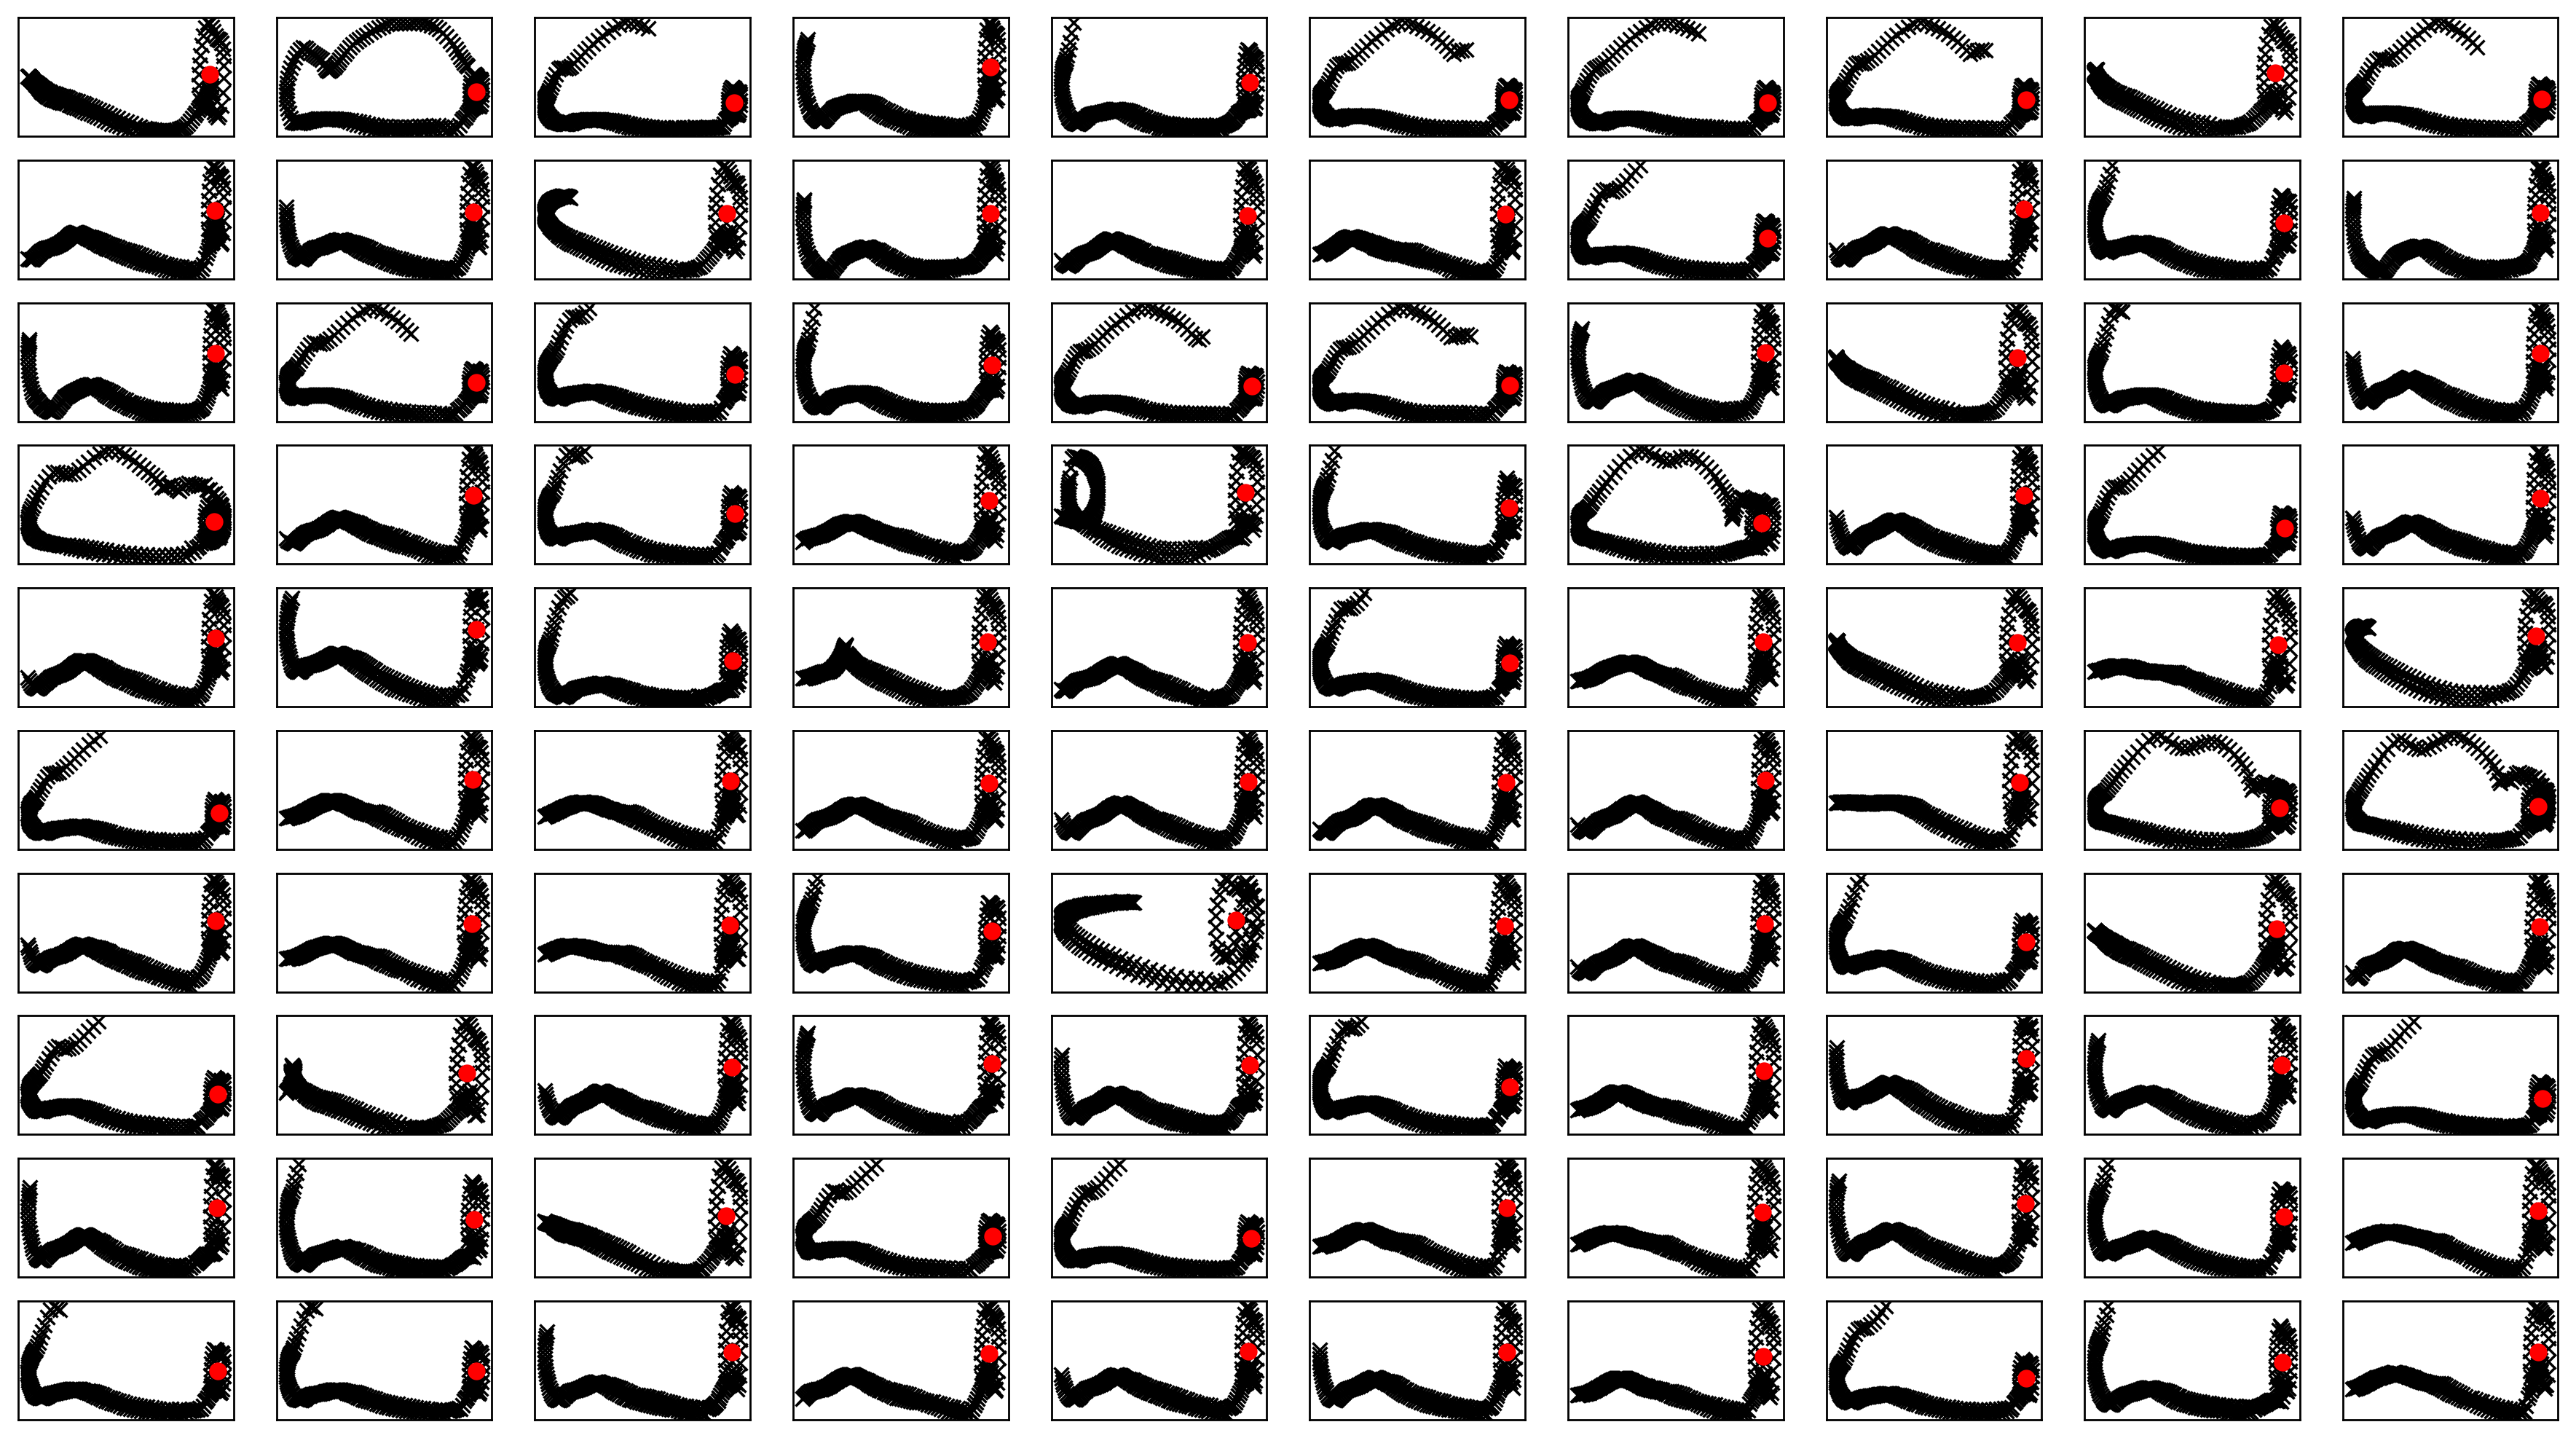

In [6]:
fig = plt.figure(figsize=(18,10), dpi=250)
fig.patch.set_facecolor('white')
ax_list = []
for i in range(len(offline_data)):
    ax_list.append(fig.add_subplot(len(offline_data)//10, 10, i+1))
    ax_list[-1].set_xticks([])
    ax_list[-1].set_yticks([])
    ax_list[-1].plot(iwvi.debug_realenv_rolloutdata[i][:,0], iwvi.debug_realenv_rolloutdata[i][:,1],"kx")
    ax_list[-1].plot(0, 0,"ro") 
plt.show()

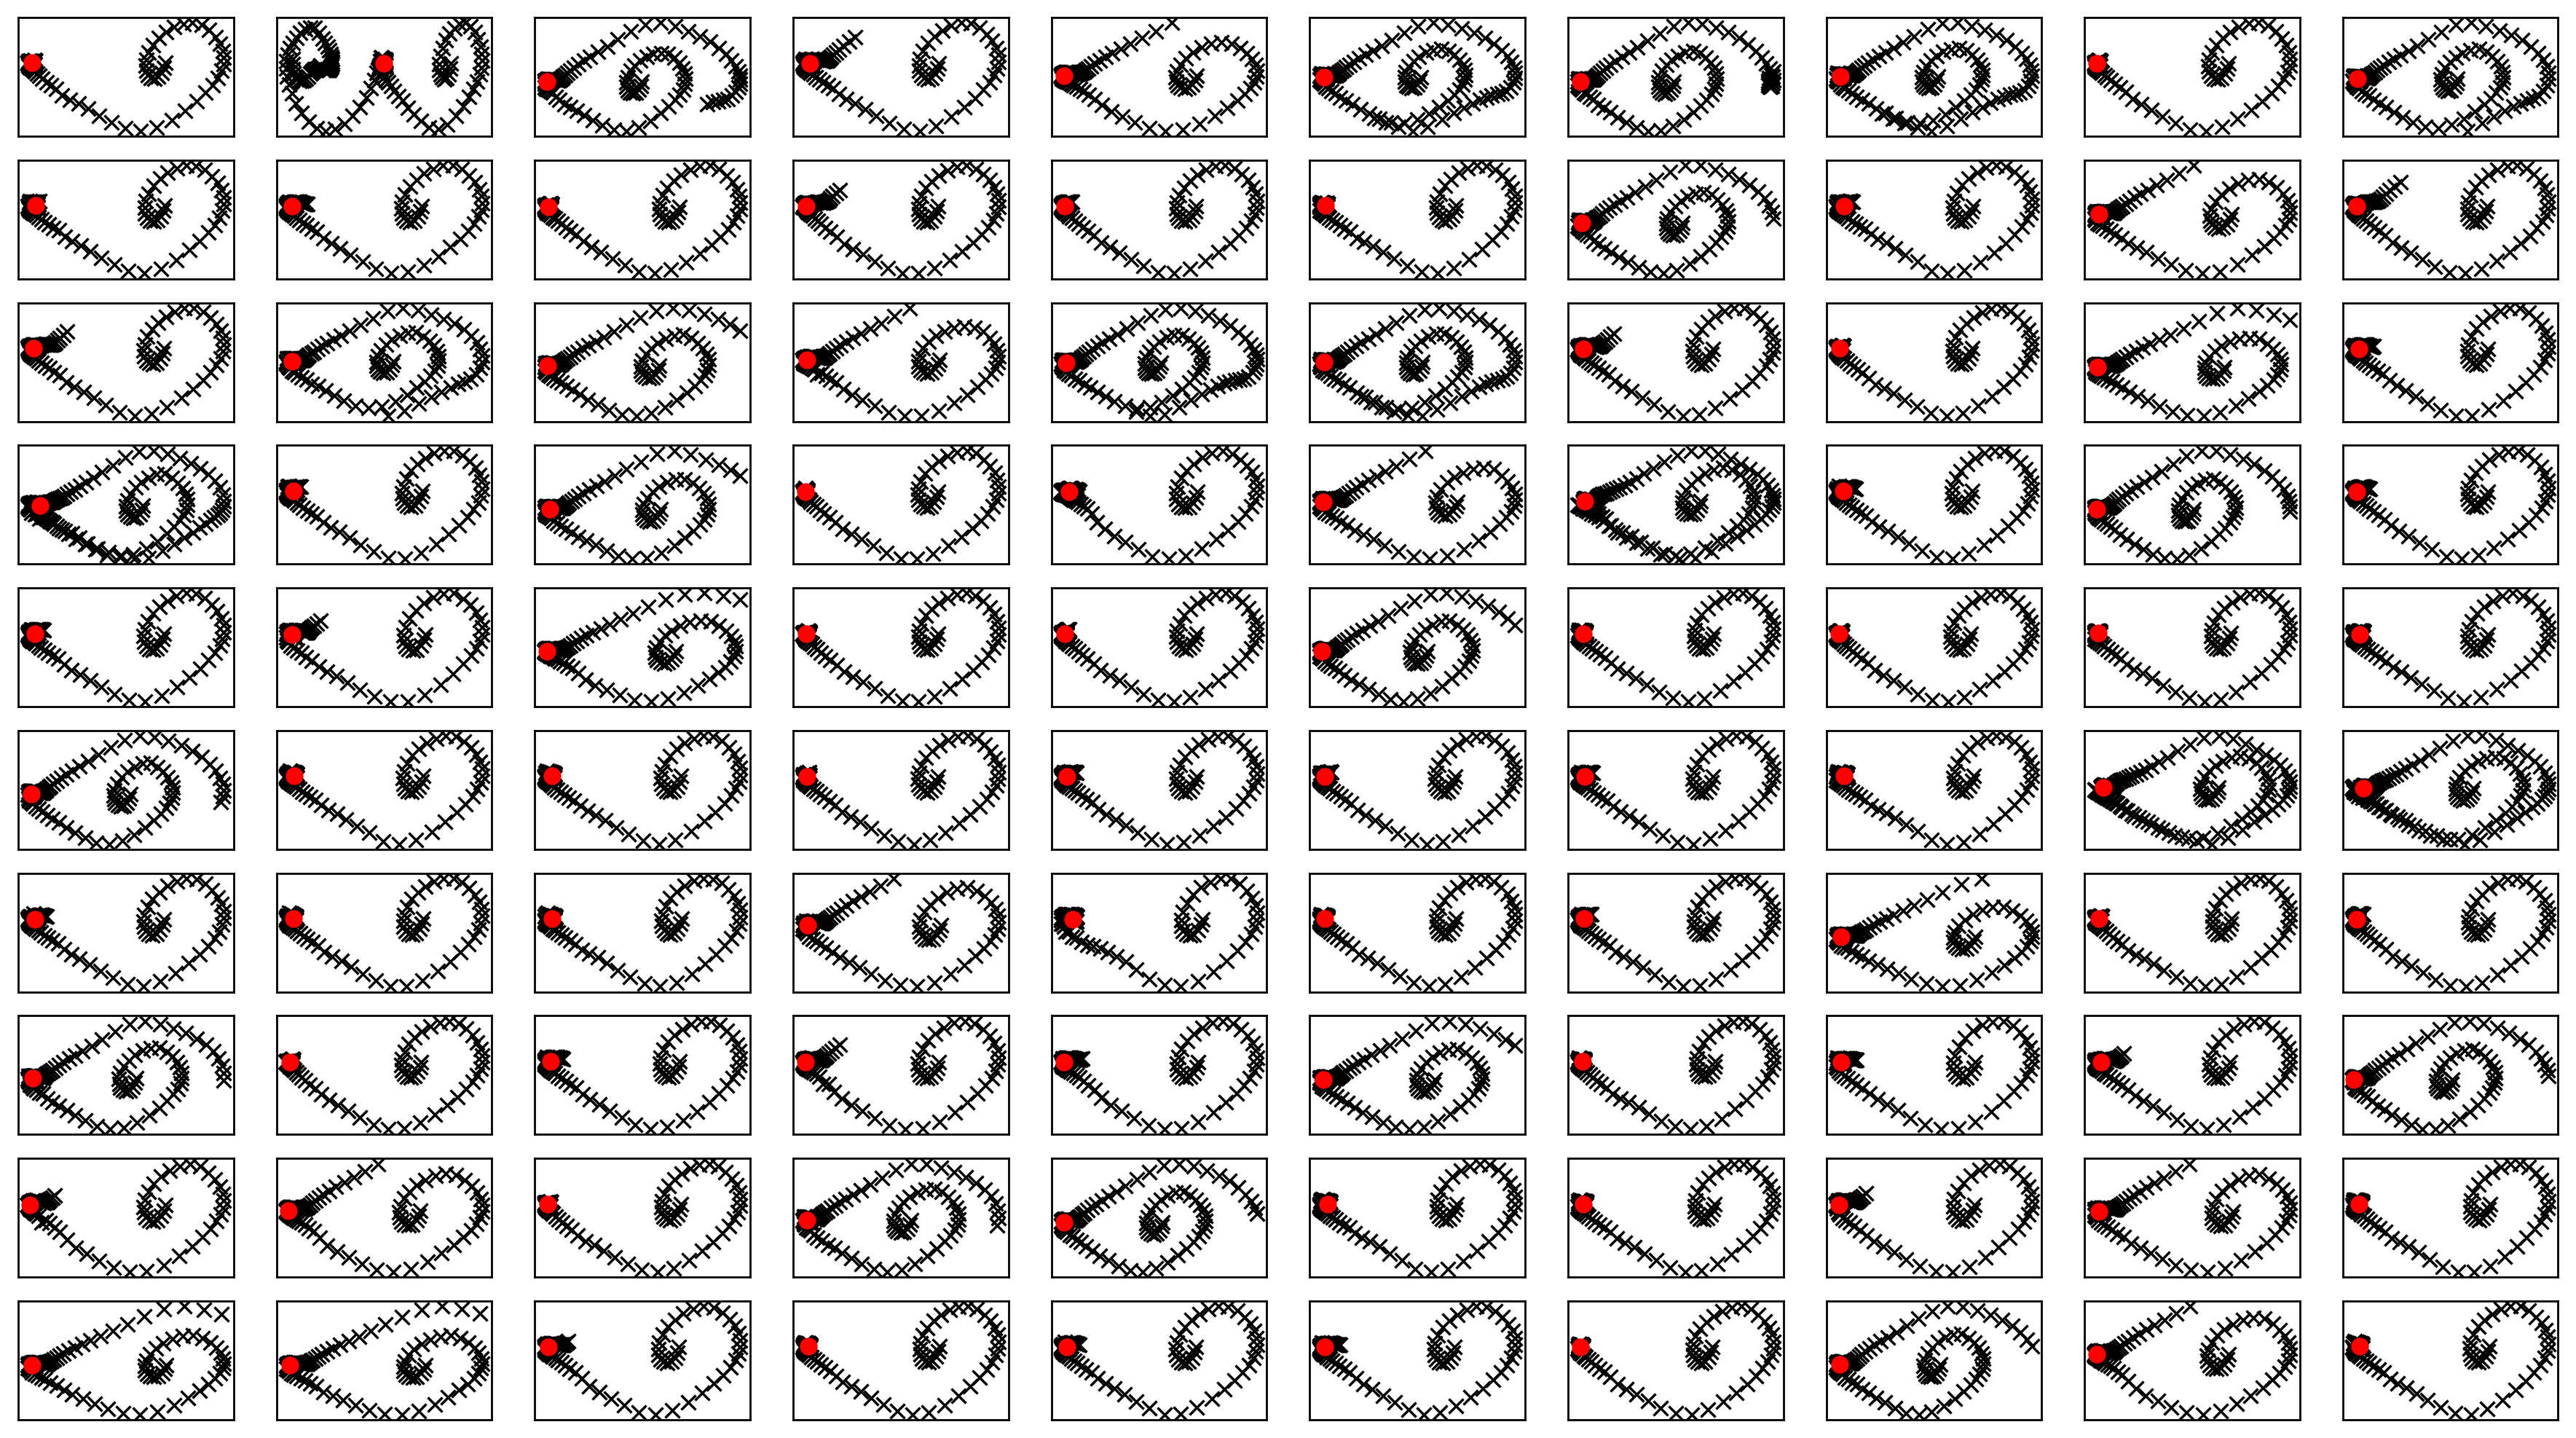

In [7]:
fig = plt.figure(figsize=(18,10), dpi=250)
fig.patch.set_facecolor('white')
ax_list = []
for i in range(len(offline_data)):
    ax_list.append(fig.add_subplot(len(offline_data)//10, 10, i+1))
    ax_list[-1].set_xticks([])
    ax_list[-1].set_yticks([])
    ax_list[-1].plot(iwvi.debug_realenv_rolloutdata[i][:,2], iwvi.debug_realenv_rolloutdata[i][:,3],"kx")
    ax_list[-1].plot(0, 0,"ro") 
plt.show()

In [8]:
print(datetime.datetime.now())

2023-07-30 16:32:03.543015


# Iter 1

In [9]:
policy_evaluation_iter=0

In [10]:
if policy_evaluation_iter<policy_evaluation_maxiter:
    iwvi.get_sim_rollout_bamdppolicy_data_randomstop()


 0

 1

 2

 3

 4

 5

 6

 7

 8

 9

 10

 11

 12

 13

 14

 15

 16

 17

 18

 19

 20

 21

 22

 23

 24

 25

 26

 27

 28

 29

 30

 31

 32

 33

 34

 35

 36

 37

 38

 39

 40

 41

 42

 43

 44

 45

 46

 47

 48

 49

 50

 51

 52

 53

 54

 55

 56

 57

 58

 59

 60

 61

 62

 63

 64

 65

 66

 67

 68

 69

 70

 71

 72

 73

 74

 75

 76

 77

 78

 79

 80

 81

 82

 83

 84

 85

 86

 87

 88

 89

 90

 91

 92

 93

 94

 95

 96

 97

 98

 99
 


In [11]:
if policy_evaluation_iter<policy_evaluation_maxiter:
    iwvi.train_ratio(num_iter=num_iter_max, lr=default_lr, early_stop_step=default_early, policy=agent.select_action)


train: iter 0  trainloss 1.32735  validloss 1.40839±0.00000  bestvalidloss 1.40839  last_update 0
train: iter 1  trainloss 1.18551  validloss 1.24178±0.00000  bestvalidloss 1.24178  last_update 0
train: iter 2  trainloss 1.05217  validloss 1.11441±0.00000  bestvalidloss 1.11441  last_update 0
train: iter 3  trainloss 0.92487  validloss 0.96481±0.00000  bestvalidloss 0.96481  last_update 0
train: iter 4  trainloss 0.81017  validloss 0.82904±0.00000  bestvalidloss 0.82904  last_update 0
train: iter 5  trainloss 0.71996  validloss 0.71641±0.00000  bestvalidloss 0.71641  last_update 0
train: iter 6  trainloss 0.65867  validloss 0.64006±0.00000  bestvalidloss 0.64006  last_update 0
train: iter 7  trainloss 0.61859  validloss 0.58752±0.00000  bestvalidloss 0.58752  last_update 0
train: iter 8  trainloss 0.59012  validloss 0.55314±0.00000  bestvalidloss 0.55314  last_update 0
train: iter 9  trainloss 0.56565  validloss 0.52434±0.00000  bestvalidloss 0.52434  last_update 0
train: iter 10  trai

train: iter 83  trainloss 0.32978  validloss 0.30070±0.00000  bestvalidloss 0.29442  last_update 1
train: iter 84  trainloss 0.33193  validloss 0.30689±0.00000  bestvalidloss 0.29442  last_update 2
train: iter 85  trainloss 0.33552  validloss 0.29208±0.00000  bestvalidloss 0.29208  last_update 0
train: iter 86  trainloss 0.32970  validloss 0.30024±0.00000  bestvalidloss 0.29208  last_update 1
train: iter 87  trainloss 0.33230  validloss 0.30751±0.00000  bestvalidloss 0.29208  last_update 2
train: iter 88  trainloss 0.33403  validloss 0.30125±0.00000  bestvalidloss 0.29208  last_update 3
train: iter 89  trainloss 0.32336  validloss 0.29704±0.00000  bestvalidloss 0.29208  last_update 4
train: iter 90  trainloss 0.32568  validloss 0.29169±0.00000  bestvalidloss 0.29169  last_update 0
train: iter 91  trainloss 0.32538  validloss 0.29061±0.00000  bestvalidloss 0.29061  last_update 0
train: iter 92  trainloss 0.32292  validloss 0.29454±0.00000  bestvalidloss 0.29061  last_update 1
train: ite

train: iter 166  trainloss 0.27447  validloss 0.24964±0.00000  bestvalidloss 0.24781  last_update 1
train: iter 167  trainloss 0.27610  validloss 0.25240±0.00000  bestvalidloss 0.24781  last_update 2
train: iter 168  trainloss 0.27428  validloss 0.24639±0.00000  bestvalidloss 0.24639  last_update 0
train: iter 169  trainloss 0.27171  validloss 0.24813±0.00000  bestvalidloss 0.24639  last_update 1
train: iter 170  trainloss 0.28411  validloss 0.25981±0.00000  bestvalidloss 0.24639  last_update 2
train: iter 171  trainloss 0.27780  validloss 0.24821±0.00000  bestvalidloss 0.24639  last_update 3
train: iter 172  trainloss 0.27543  validloss 0.24870±0.00000  bestvalidloss 0.24639  last_update 4
train: iter 173  trainloss 0.28793  validloss 0.24850±0.00000  bestvalidloss 0.24639  last_update 5
train: iter 174  trainloss 0.28250  validloss 0.25303±0.00000  bestvalidloss 0.24639  last_update 6
train: iter 175  trainloss 0.27433  validloss 0.25572±0.00000  bestvalidloss 0.24639  last_update 7


train: iter 249  trainloss 0.25067  validloss 0.25685±0.00000  bestvalidloss 0.22912  last_update 9
train: iter 250  trainloss 0.25506  validloss 0.23873±0.00000  bestvalidloss 0.22912  last_update 10
train: iter 251  trainloss 0.24935  validloss 0.22723±0.00000  bestvalidloss 0.22723  last_update 0
train: iter 252  trainloss 0.25326  validloss 0.24328±0.00000  bestvalidloss 0.22723  last_update 1
train: iter 253  trainloss 0.25335  validloss 0.24201±0.00000  bestvalidloss 0.22723  last_update 2
train: iter 254  trainloss 0.25685  validloss 0.23162±0.00000  bestvalidloss 0.22723  last_update 3
train: iter 255  trainloss 0.26092  validloss 0.22786±0.00000  bestvalidloss 0.22723  last_update 4
train: iter 256  trainloss 0.24661  validloss 0.24047±0.00000  bestvalidloss 0.22723  last_update 5
train: iter 257  trainloss 0.24913  validloss 0.25471±0.00000  bestvalidloss 0.22723  last_update 6
train: iter 258  trainloss 0.24757  validloss 0.23050±0.00000  bestvalidloss 0.22723  last_update 7

train: iter 331  trainloss 0.23618  validloss 0.21185±0.00000  bestvalidloss 0.20832  last_update 10
train: iter 332  trainloss 0.23375  validloss 0.20741±0.00000  bestvalidloss 0.20741  last_update 0
train: iter 333  trainloss 0.23656  validloss 0.22950±0.00000  bestvalidloss 0.20741  last_update 1
train: iter 334  trainloss 0.23375  validloss 0.20852±0.00000  bestvalidloss 0.20741  last_update 2
train: iter 335  trainloss 0.23263  validloss 0.20751±0.00000  bestvalidloss 0.20741  last_update 3
train: iter 336  trainloss 0.23866  validloss 0.22324±0.00000  bestvalidloss 0.20741  last_update 4
train: iter 337  trainloss 0.23335  validloss 0.23023±0.00000  bestvalidloss 0.20741  last_update 5
train: iter 338  trainloss 0.23572  validloss 0.21726±0.00000  bestvalidloss 0.20741  last_update 6
train: iter 339  trainloss 0.23616  validloss 0.21586±0.00000  bestvalidloss 0.20741  last_update 7
train: iter 340  trainloss 0.23625  validloss 0.21105±0.00000  bestvalidloss 0.20741  last_update 8

train: iter 413  trainloss 0.22251  validloss 0.19922±0.00000  bestvalidloss 0.19427  last_update 21
train: iter 414  trainloss 0.22080  validloss 0.19892±0.00000  bestvalidloss 0.19427  last_update 22
train: iter 415  trainloss 0.21976  validloss 0.20460±0.00000  bestvalidloss 0.19427  last_update 23
train: iter 416  trainloss 0.21723  validloss 0.19697±0.00000  bestvalidloss 0.19427  last_update 24
train: iter 417  trainloss 0.22028  validloss 0.21573±0.00000  bestvalidloss 0.19427  last_update 25
train: iter 418  trainloss 0.22626  validloss 0.20519±0.00000  bestvalidloss 0.19427  last_update 26
train: iter 419  trainloss 0.22248  validloss 0.19665±0.00000  bestvalidloss 0.19427  last_update 27
train: iter 420  trainloss 0.21979  validloss 0.19627±0.00000  bestvalidloss 0.19427  last_update 28
train: iter 421  trainloss 0.22541  validloss 0.19600±0.00000  bestvalidloss 0.19427  last_update 29
train: iter 422  trainloss 0.22322  validloss 0.19754±0.00000  bestvalidloss 0.19427  last_

train: iter 495  trainloss 0.20649  validloss 0.18730±0.00000  bestvalidloss 0.18546  last_update 4
train: iter 496  trainloss 0.21358  validloss 0.18907±0.00000  bestvalidloss 0.18546  last_update 5
train: iter 497  trainloss 0.20505  validloss 0.19047±0.00000  bestvalidloss 0.18546  last_update 6
train: iter 498  trainloss 0.20602  validloss 0.19342±0.00000  bestvalidloss 0.18546  last_update 7
train: iter 499  trainloss 0.21308  validloss 0.19436±0.00000  bestvalidloss 0.18546  last_update 8
train: iter 500  trainloss 0.20605  validloss 0.19004±0.00000  bestvalidloss 0.18546  last_update 9
train: iter 501  trainloss 0.20674  validloss 0.18394±0.00000  bestvalidloss 0.18394  last_update 0
train: iter 502  trainloss 0.20503  validloss 0.18815±0.00000  bestvalidloss 0.18394  last_update 1
train: iter 503  trainloss 0.20821  validloss 0.19613±0.00000  bestvalidloss 0.18394  last_update 2
train: iter 504  trainloss 0.20692  validloss 0.20131±0.00000  bestvalidloss 0.18394  last_update 3


train: iter 577  trainloss 0.19686  validloss 0.18887±0.00000  bestvalidloss 0.17933  last_update 35
train: iter 578  trainloss 0.20365  validloss 0.19039±0.00000  bestvalidloss 0.17933  last_update 36
train: iter 579  trainloss 0.19698  validloss 0.20418±0.00000  bestvalidloss 0.17933  last_update 37
train: iter 580  trainloss 0.19933  validloss 0.18624±0.00000  bestvalidloss 0.17933  last_update 38
train: iter 581  trainloss 0.19784  validloss 0.19003±0.00000  bestvalidloss 0.17933  last_update 39
train: iter 582  trainloss 0.19968  validloss 0.19628±0.00000  bestvalidloss 0.17933  last_update 40
train: iter 583  trainloss 0.20022  validloss 0.19704±0.00000  bestvalidloss 0.17933  last_update 41
train: iter 584  trainloss 0.19648  validloss 0.18682±0.00000  bestvalidloss 0.17933  last_update 42
train: iter 585  trainloss 0.19817  validloss 0.18795±0.00000  bestvalidloss 0.17933  last_update 43
train: iter 586  trainloss 0.20216  validloss 0.18787±0.00000  bestvalidloss 0.17933  last_

train: iter 659  trainloss 0.19288  validloss 0.18990±0.00000  bestvalidloss 0.17684  last_update 5
train: iter 660  trainloss 0.18893  validloss 0.18752±0.00000  bestvalidloss 0.17684  last_update 6
train: iter 661  trainloss 0.19160  validloss 0.18284±0.00000  bestvalidloss 0.17684  last_update 7
train: iter 662  trainloss 0.18883  validloss 0.18479±0.00000  bestvalidloss 0.17684  last_update 8
train: iter 663  trainloss 0.19069  validloss 0.19174±0.00000  bestvalidloss 0.17684  last_update 9
train: iter 664  trainloss 0.18799  validloss 0.18024±0.00000  bestvalidloss 0.17684  last_update 10
train: iter 665  trainloss 0.19031  validloss 0.17908±0.00000  bestvalidloss 0.17684  last_update 11
train: iter 666  trainloss 0.19061  validloss 0.17659±0.00000  bestvalidloss 0.17659  last_update 0
train: iter 667  trainloss 0.19036  validloss 0.18296±0.00000  bestvalidloss 0.17659  last_update 1
train: iter 668  trainloss 0.18985  validloss 0.18292±0.00000  bestvalidloss 0.17659  last_update 

train: iter 741  trainloss 0.18382  validloss 0.18661±0.00000  bestvalidloss 0.17630  last_update 21
train: iter 742  trainloss 0.18151  validloss 0.18670±0.00000  bestvalidloss 0.17630  last_update 22
train: iter 743  trainloss 0.18276  validloss 0.17740±0.00000  bestvalidloss 0.17630  last_update 23
train: iter 744  trainloss 0.18112  validloss 0.18206±0.00000  bestvalidloss 0.17630  last_update 24
train: iter 745  trainloss 0.18132  validloss 0.17965±0.00000  bestvalidloss 0.17630  last_update 25
train: iter 746  trainloss 0.18284  validloss 0.18229±0.00000  bestvalidloss 0.17630  last_update 26
train: iter 747  trainloss 0.18318  validloss 0.19107±0.00000  bestvalidloss 0.17630  last_update 27
train: iter 748  trainloss 0.18313  validloss 0.18486±0.00000  bestvalidloss 0.17630  last_update 28
train: iter 749  trainloss 0.17997  validloss 0.18236±0.00000  bestvalidloss 0.17630  last_update 29
train: iter 750  trainloss 0.18257  validloss 0.18690±0.00000  bestvalidloss 0.17630  last_

train: iter 823  trainloss 0.17671  validloss 0.18292±0.00000  bestvalidloss 0.17564  last_update 3
train: iter 824  trainloss 0.17796  validloss 0.18900±0.00000  bestvalidloss 0.17564  last_update 4
train: iter 825  trainloss 0.17583  validloss 0.18675±0.00000  bestvalidloss 0.17564  last_update 5
train: iter 826  trainloss 0.17913  validloss 0.18228±0.00000  bestvalidloss 0.17564  last_update 6
train: iter 827  trainloss 0.18179  validloss 0.18191±0.00000  bestvalidloss 0.17564  last_update 7
train: iter 828  trainloss 0.17843  validloss 0.17807±0.00000  bestvalidloss 0.17564  last_update 8
train: iter 829  trainloss 0.17619  validloss 0.17786±0.00000  bestvalidloss 0.17564  last_update 9
train: iter 830  trainloss 0.17829  validloss 0.17852±0.00000  bestvalidloss 0.17564  last_update 10
train: iter 831  trainloss 0.17600  validloss 0.20079±0.00000  bestvalidloss 0.17564  last_update 11
train: iter 832  trainloss 0.17513  validloss 0.17822±0.00000  bestvalidloss 0.17564  last_update 

train: iter 905  trainloss 0.17567  validloss 0.17867±0.00000  bestvalidloss 0.17564  last_update 85
train: iter 906  trainloss 0.17222  validloss 0.19922±0.00000  bestvalidloss 0.17564  last_update 86
train: iter 907  trainloss 0.17136  validloss 0.18143±0.00000  bestvalidloss 0.17564  last_update 87
train: iter 908  trainloss 0.17507  validloss 0.18575±0.00000  bestvalidloss 0.17564  last_update 88
train: iter 909  trainloss 0.17108  validloss 0.18287±0.00000  bestvalidloss 0.17564  last_update 89
train: iter 910  trainloss 0.17072  validloss 0.18483±0.00000  bestvalidloss 0.17564  last_update 90
train: iter 911  trainloss 0.17379  validloss 0.17922±0.00000  bestvalidloss 0.17564  last_update 91
train: iter 912  trainloss 0.17070  validloss 0.18053±0.00000  bestvalidloss 0.17564  last_update 92
train: iter 913  trainloss 0.17058  validloss 0.18549±0.00000  bestvalidloss 0.17564  last_update 93
train: iter 914  trainloss 0.17017  validloss 0.18399±0.00000  bestvalidloss 0.17564  last_

train_loss:  -3.608244727066159
valid_loss:  -3.023933338236809
weight_alpha 1.0 h_min_tilde -11.833602 ell_tilde -3.491382449300289 kappa_tilde 0.00034622561354027547
train_loss:  -2.905610296344757
valid_loss:  -2.6120431407928466
weight_alpha 0.1 h_min_tilde -11.833602 ell_tilde -2.846896865234375 kappa_tilde 0.00033357980854354996


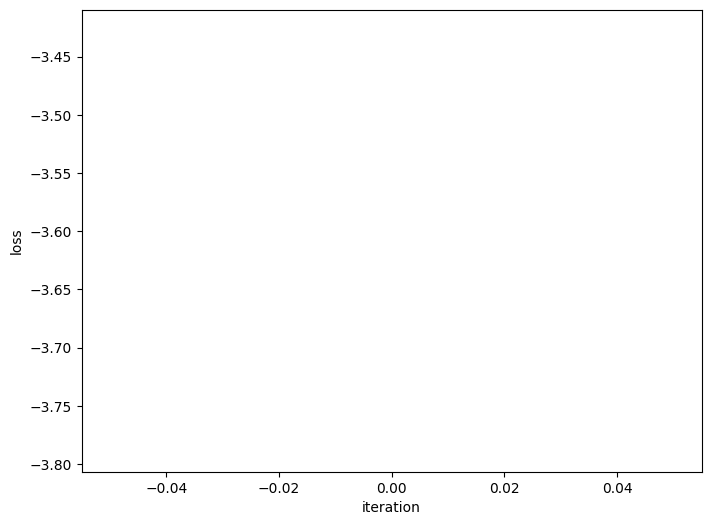

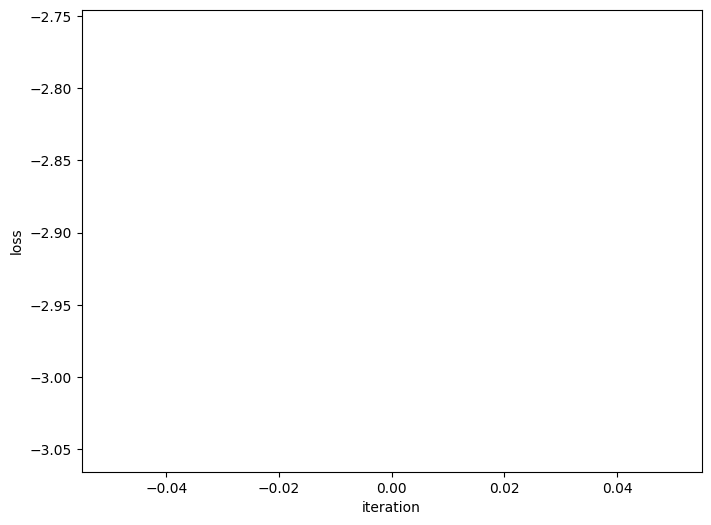

In [12]:
loss_list.append(iwvi.eval_loss(weight_alpha=1.))
normalized_loss_list.append(iwvi.eval_loss(weight_alpha=alpha))
if policy_evaluation_iter<policy_evaluation_maxiter:
    loss_array = np.array(loss_list)
    plt.figure(figsize=(8,6))
    plt.plot(loss_array[:,0])
    plt.xlabel("iteration")
    plt.ylabel("loss")
    plt.show()
    
    normalized_loss_array = np.array(normalized_loss_list)
    plt.figure(figsize=(8,6))
    plt.plot(normalized_loss_array[:,0])
    plt.xlabel("iteration")
    plt.ylabel("loss")

In [13]:
if policy_evaluation_iter<policy_evaluation_maxiter:
    train_curve1, valid_curve1 = iwvi.train_weighted_vae(num_iter=num_iter_max, lr=default_lr, early_stop_step=default_early, weight_alpha=alpha, flag=1)
    iwvi.update_mulogvar_offlinedata()

weight_alpha 0.1
train_weighted_vae: enc_dec
train: iter 0  trainloss -538.97684  validloss -522.33536±0.00000  bestvalidloss -522.33536  last_update 0
train: iter 1  trainloss -566.38930  validloss -505.44404±0.00000  bestvalidloss -522.33536  last_update 1
train: iter 2  trainloss -543.01459  validloss -459.53720±0.00000  bestvalidloss -522.33536  last_update 2
train: iter 3  trainloss -573.41000  validloss -504.77006±0.00000  bestvalidloss -522.33536  last_update 3
train: iter 4  trainloss -562.06491  validloss -491.75813±0.00000  bestvalidloss -522.33536  last_update 4
train: iter 5  trainloss -569.33160  validloss -440.83592±0.00000  bestvalidloss -522.33536  last_update 5
train: iter 6  trainloss -577.58578  validloss -516.12393±0.00000  bestvalidloss -522.33536  last_update 6
train: iter 7  trainloss -552.24097  validloss -503.95461±0.00000  bestvalidloss -522.33536  last_update 7
train: iter 8  trainloss -555.26757  validloss -456.48022±0.00000  bestvalidloss -522.33536  last_u

train: iter 75  trainloss -577.06647  validloss -494.18728±0.00000  bestvalidloss -522.33536  last_update 75
train: iter 76  trainloss -576.64156  validloss -496.15070±0.00000  bestvalidloss -522.33536  last_update 76
train: iter 77  trainloss -565.52295  validloss -456.17239±0.00000  bestvalidloss -522.33536  last_update 77
train: iter 78  trainloss -588.83360  validloss -504.33259±0.00000  bestvalidloss -522.33536  last_update 78
train: iter 79  trainloss -587.51376  validloss -516.22371±0.00000  bestvalidloss -522.33536  last_update 79
train: iter 80  trainloss -536.82736  validloss -520.48505±0.00000  bestvalidloss -522.33536  last_update 80
train: iter 81  trainloss -573.76704  validloss -490.56996±0.00000  bestvalidloss -522.33536  last_update 81
train: iter 82  trainloss -579.45207  validloss -488.66916±0.00000  bestvalidloss -522.33536  last_update 82
train: iter 83  trainloss -585.74711  validloss -507.39992±0.00000  bestvalidloss -522.33536  last_update 83
train: iter 84  tra

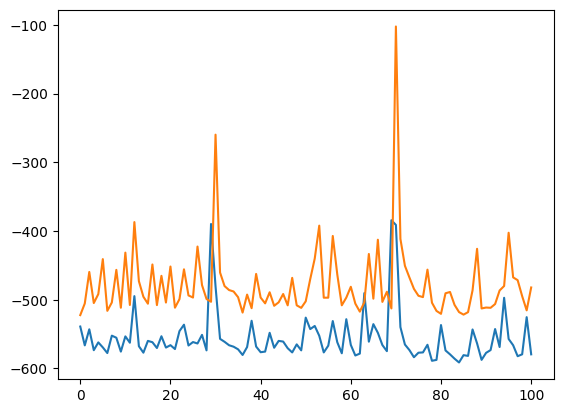

alpha 0.1 default_lr 0.0005


In [14]:
if policy_evaluation_iter<policy_evaluation_maxiter:
    plt.plot(train_curve1)
    plt.plot(valid_curve1)
    plt.show()
    print("alpha",alpha, "default_lr", default_lr)

In [15]:
# iwvi.get_sim_rollout_bamdppolicy_data_fixlen()
# simdata0a = copy.deepcopy(iwvi.simenv_rolloutdata)
# iwvi.get_sim_rollout_bamdppolicy_data_fixlen()
# simdata0b = copy.deepcopy(iwvi.simenv_rolloutdata)
# # iwvi.get_sim_rollout_bamdppolicy_data_fixlen()
# # simdata0c = copy.deepcopy(iwvi.simenv_rolloutdata)



In [16]:
print(datetime.datetime.now())

2023-07-30 16:58:47.481753


# Iter2

In [17]:
policy_evaluation_iter=1

In [18]:
if policy_evaluation_iter<policy_evaluation_maxiter:
    iwvi.get_sim_rollout_bamdppolicy_data_randomstop()


 0

 1

 2

 3

 4

 5

 6

 7

 8

 9

 10

 11

 12

 13

 14

 15

 16

 17

 18

 19

 20

 21

 22

 23

 24

 25

 26

 27

 28

 29

 30

 31

 32

 33

 34

 35

 36

 37

 38

 39

 40

 41

 42

 43

 44

 45

 46

 47

 48

 49

 50

 51

 52

 53

 54

 55

 56

 57

 58

 59

 60

 61

 62

 63

 64

 65

 66

 67

 68

 69

 70

 71

 72

 73

 74

 75

 76

 77

 78

 79

 80

 81

 82

 83

 84

 85

 86

 87

 88

 89

 90

 91

 92

 93

 94

 95

 96

 97

 98

 99
 


In [19]:
if policy_evaluation_iter<policy_evaluation_maxiter:
    iwvi.train_ratio(num_iter=num_iter_max, lr=default_lr, early_stop_step=default_early, policy=agent.select_action)


train: iter 0  trainloss 0.54519  validloss 2.30326±0.00000  bestvalidloss 2.30326  last_update 0
train: iter 1  trainloss 0.37398  validloss 0.35732±0.00000  bestvalidloss 0.35732  last_update 0
train: iter 2  trainloss 0.34518  validloss 0.32408±0.00000  bestvalidloss 0.32408  last_update 0
train: iter 3  trainloss 0.32084  validloss 0.28221±0.00000  bestvalidloss 0.28221  last_update 0
train: iter 4  trainloss 0.30318  validloss 0.26162±0.00000  bestvalidloss 0.26162  last_update 0
train: iter 5  trainloss 0.29594  validloss 0.24080±0.00000  bestvalidloss 0.24080  last_update 0
train: iter 6  trainloss 0.28518  validloss 0.23442±0.00000  bestvalidloss 0.23442  last_update 0
train: iter 7  trainloss 0.28209  validloss 0.21864±0.00000  bestvalidloss 0.21864  last_update 0
train: iter 8  trainloss 0.28088  validloss 0.22557±0.00000  bestvalidloss 0.21864  last_update 1
train: iter 9  trainloss 0.27315  validloss 0.21602±0.00000  bestvalidloss 0.21602  last_update 0
train: iter 10  trai

train: iter 83  trainloss 0.22503  validloss 0.23364±0.00000  bestvalidloss 0.20616  last_update 43
train: iter 84  trainloss 0.22161  validloss 0.21780±0.00000  bestvalidloss 0.20616  last_update 44
train: iter 85  trainloss 0.22364  validloss 0.21049±0.00000  bestvalidloss 0.20616  last_update 45
train: iter 86  trainloss 0.22559  validloss 0.20650±0.00000  bestvalidloss 0.20616  last_update 46
train: iter 87  trainloss 0.22174  validloss 0.20613±0.00000  bestvalidloss 0.20613  last_update 0
train: iter 88  trainloss 0.22296  validloss 0.21584±0.00000  bestvalidloss 0.20613  last_update 1
train: iter 89  trainloss 0.22486  validloss 0.21573±0.00000  bestvalidloss 0.20613  last_update 2
train: iter 90  trainloss 0.22246  validloss 0.21515±0.00000  bestvalidloss 0.20613  last_update 3
train: iter 91  trainloss 0.22301  validloss 0.21193±0.00000  bestvalidloss 0.20613  last_update 4
train: iter 92  trainloss 0.21962  validloss 0.20802±0.00000  bestvalidloss 0.20613  last_update 5
train:

train: iter 165  trainloss 0.21179  validloss 0.21638±0.00000  bestvalidloss 0.19724  last_update 24
train: iter 166  trainloss 0.20896  validloss 0.20467±0.00000  bestvalidloss 0.19724  last_update 25
train: iter 167  trainloss 0.21058  validloss 0.21030±0.00000  bestvalidloss 0.19724  last_update 26
train: iter 168  trainloss 0.20960  validloss 0.20258±0.00000  bestvalidloss 0.19724  last_update 27
train: iter 169  trainloss 0.21079  validloss 0.20902±0.00000  bestvalidloss 0.19724  last_update 28
train: iter 170  trainloss 0.21165  validloss 0.20692±0.00000  bestvalidloss 0.19724  last_update 29
train: iter 171  trainloss 0.21008  validloss 0.20851±0.00000  bestvalidloss 0.19724  last_update 30
train: iter 172  trainloss 0.20751  validloss 0.21609±0.00000  bestvalidloss 0.19724  last_update 31
train: iter 173  trainloss 0.20731  validloss 0.20143±0.00000  bestvalidloss 0.19724  last_update 32
train: iter 174  trainloss 0.20852  validloss 0.21652±0.00000  bestvalidloss 0.19724  last_

train_loss:  -3.6401931520223627
valid_loss:  -3.711375614500046
weight_alpha 1.0 h_min_tilde -12.009785 ell_tilde -3.654429644517899 kappa_tilde 0.00034595335381876923
train_loss:  -3.2690605944633475
valid_loss:  -2.844683543395996
weight_alpha 0.1 h_min_tilde -12.009785 ell_tilde -3.1841851842498774 kappa_tilde 0.0003366106805403537


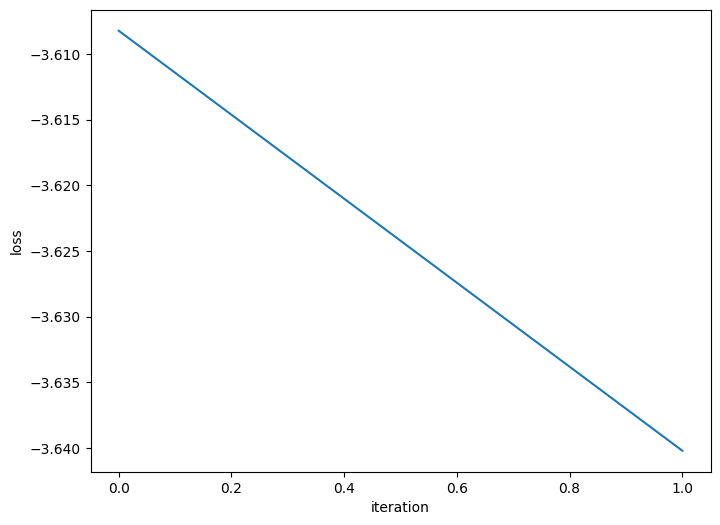

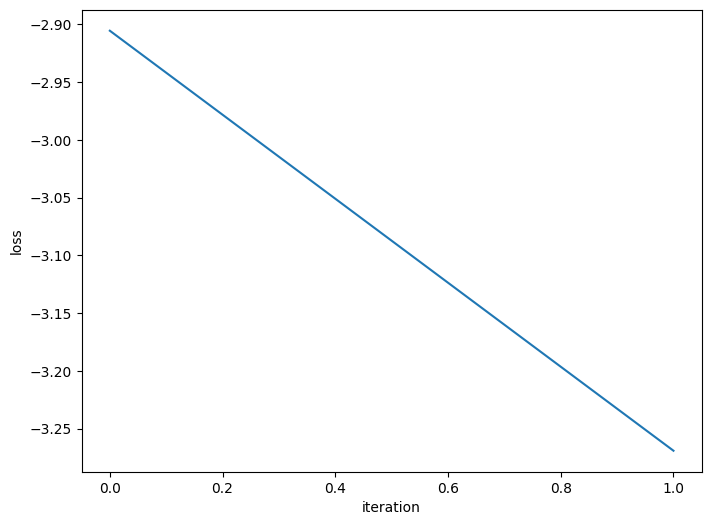

In [20]:
if policy_evaluation_iter<policy_evaluation_maxiter:
    loss_list.append(iwvi.eval_loss(weight_alpha=1.))
    normalized_loss_list.append(iwvi.eval_loss(weight_alpha=alpha))
if policy_evaluation_iter<policy_evaluation_maxiter:
    loss_array = np.array(loss_list)
    plt.figure(figsize=(8,6))
    plt.plot(loss_array[:,0])
    plt.xlabel("iteration")
    plt.ylabel("loss")
    plt.show()
    
    normalized_loss_array = np.array(normalized_loss_list)
    plt.figure(figsize=(8,6))
    plt.plot(normalized_loss_array[:,0])
    plt.xlabel("iteration")
    plt.ylabel("loss")

In [21]:
if policy_evaluation_iter<policy_evaluation_maxiter:
    train_curve1, valid_curve1 = iwvi.train_weighted_vae(num_iter=num_iter_max, lr=default_lr, early_stop_step=default_early, weight_alpha=alpha, flag=1)
    iwvi.update_mulogvar_offlinedata()


weight_alpha 0.1
train_weighted_vae: enc_dec
train: iter 0  trainloss -640.18299  validloss -566.35368±0.00000  bestvalidloss -566.35368  last_update 0
train: iter 1  trainloss -625.59092  validloss -548.26970±0.00000  bestvalidloss -566.35368  last_update 1
train: iter 2  trainloss -604.08065  validloss -496.26719±0.00000  bestvalidloss -566.35368  last_update 2
train: iter 3  trainloss -614.19506  validloss -418.96681±0.00000  bestvalidloss -566.35368  last_update 3
train: iter 4  trainloss -632.84649  validloss -563.52938±0.00000  bestvalidloss -566.35368  last_update 4
train: iter 5  trainloss -625.38768  validloss -170.32524±0.00000  bestvalidloss -566.35368  last_update 5
train: iter 6  trainloss -648.78171  validloss -589.95911±0.00000  bestvalidloss -589.95911  last_update 0
train: iter 7  trainloss -636.05377  validloss -544.89588±0.00000  bestvalidloss -589.95911  last_update 1
train: iter 8  trainloss -651.23719  validloss -517.94215±0.00000  bestvalidloss -589.95911  last_u

train: iter 76  trainloss -656.30950  validloss -557.24064±0.00000  bestvalidloss -597.78592  last_update 51
train: iter 77  trainloss -628.22855  validloss -598.58105±0.00000  bestvalidloss -598.58105  last_update 0
train: iter 78  trainloss -627.21183  validloss -564.48459±0.00000  bestvalidloss -598.58105  last_update 1
train: iter 79  trainloss -642.64943  validloss -537.49030±0.00000  bestvalidloss -598.58105  last_update 2
train: iter 80  trainloss -645.61151  validloss -568.33248±0.00000  bestvalidloss -598.58105  last_update 3
train: iter 81  trainloss -657.09880  validloss -574.95878±0.00000  bestvalidloss -598.58105  last_update 4
train: iter 82  trainloss -656.36884  validloss -568.60140±0.00000  bestvalidloss -598.58105  last_update 5
train: iter 83  trainloss -620.60204  validloss -565.90138±0.00000  bestvalidloss -598.58105  last_update 6
train: iter 84  trainloss -646.43142  validloss -572.85552±0.00000  bestvalidloss -598.58105  last_update 7
train: iter 85  trainloss -

train: iter 151  trainloss -633.30394  validloss -559.85700±0.00000  bestvalidloss -599.82177  last_update 65
train: iter 152  trainloss -623.19175  validloss -565.53244±0.00000  bestvalidloss -599.82177  last_update 66
train: iter 153  trainloss -639.57692  validloss -576.08252±0.00000  bestvalidloss -599.82177  last_update 67
train: iter 154  trainloss -636.67372  validloss -527.68392±0.00000  bestvalidloss -599.82177  last_update 68
train: iter 155  trainloss -640.46208  validloss -578.88393±0.00000  bestvalidloss -599.82177  last_update 69
train: iter 156  trainloss -619.48543  validloss -484.06766±0.00000  bestvalidloss -599.82177  last_update 70
train: iter 157  trainloss -639.41361  validloss -545.04361±0.00000  bestvalidloss -599.82177  last_update 71
train: iter 158  trainloss -607.79561  validloss -587.48133±0.00000  bestvalidloss -599.82177  last_update 72
train: iter 159  trainloss -639.37775  validloss -533.15192±0.00000  bestvalidloss -599.82177  last_update 73
train: ite

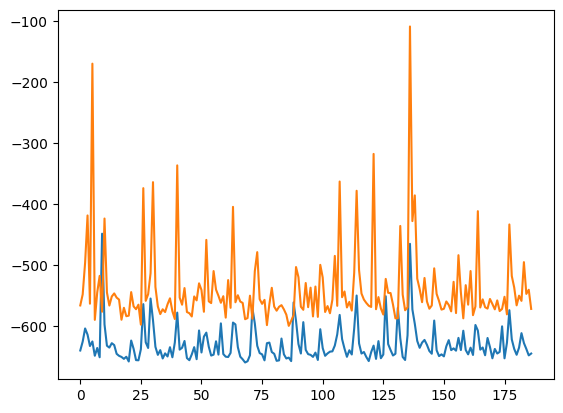

alpha 0.1 default_lr 0.0005


In [22]:
if policy_evaluation_iter<policy_evaluation_maxiter:
    plt.plot(train_curve1)
    plt.plot(valid_curve1)
    plt.show()
print("alpha",alpha, "default_lr", default_lr)

In [23]:
# iwvi.get_sim_rollout_bamdppolicy_data_fixlen()
# simdata0a = copy.deepcopy(iwvi.simenv_rolloutdata)
# iwvi.get_sim_rollout_bamdppolicy_data_fixlen()
# simdata0b = copy.deepcopy(iwvi.simenv_rolloutdata)
# # iwvi.get_sim_rollout_bamdppolicy_data_fixlen()
# # simdata0c = copy.deepcopy(iwvi.simenv_rolloutdata)


In [24]:
print(datetime.datetime.now())

2023-07-30 17:22:27.223484


In [25]:
# if policy_evaluation_iter<policy_evaluation_maxiter:
#     normalized_loss_array = np.array(normalized_loss_list)
#     plt.figure(figsize=(16,12))
#     plt.plot(normalized_loss_array[:,0])
#     plt.xlabel("iteration")
#     plt.ylabel("loss")


# Iter 3

In [26]:
policy_evaluation_iter=2

In [27]:
if policy_evaluation_iter<policy_evaluation_maxiter:
    iwvi.get_sim_rollout_bamdppolicy_data_randomstop()


 0

 1

 2

 3

 4

 5

 6

 7

 8

 9

 10

 11

 12

 13

 14

 15

 16

 17

 18

 19

 20
predict diverge [  1.46983128   9.87256375 -30.16047701 -29.12487798] [ 0.3065932   2.41678526 -1.2346756  -4.15927152] [139.468     23.342175 153.2716    28.861576] [69.734    11.671087 76.6358   14.430788] sim_timestep 179

 21

 22

 23

 24

 25

 26

 27

 28

 29

 30

 31

 32

 33

 34

 35

 36

 37
predict diverge [ -3.37126196  16.25704161 -19.46219453 -53.7599277 ] [  0.55868938   4.91319987  -1.18188007 -26.64478038] [139.468     23.342175 153.2716    28.861576] [69.734    11.671087 76.6358   14.430788] sim_timestep 169

 38

 39

 40

 41

 42

 43

 44

 45

 46

 47

 48

 49

 50

 51

 52

 53

 54

 55

 56

 57

 58

 59

 60

 61

 62

 63

 64

 65

 66

 67

 68

 69

 70

 71

 72

 73

 74

 75

 76

 77

 78

 79

 80

 81

 82

 83

 84

 85

 86

 87

 88

 89

 90

 91

 92

 93

 94

 95

 96

 97

 98

 99
 


In [28]:
if policy_evaluation_iter<policy_evaluation_maxiter:
    iwvi.train_ratio(num_iter=num_iter_max, lr=default_lr, early_stop_step=default_early, policy=agent.select_action)


train: iter 0  trainloss 0.33915  validloss 0.34711±0.00000  bestvalidloss 0.34711  last_update 0
train: iter 1  trainloss 0.29936  validloss 0.24049±0.00000  bestvalidloss 0.24049  last_update 0
train: iter 2  trainloss 0.29341  validloss 0.23492±0.00000  bestvalidloss 0.23492  last_update 0
train: iter 3  trainloss 0.28308  validloss 0.22970±0.00000  bestvalidloss 0.22970  last_update 0
train: iter 4  trainloss 0.27791  validloss 0.22085±0.00000  bestvalidloss 0.22085  last_update 0
train: iter 5  trainloss 0.27721  validloss 0.22404±0.00000  bestvalidloss 0.22085  last_update 1
train: iter 6  trainloss 0.27227  validloss 0.22246±0.00000  bestvalidloss 0.22085  last_update 2
train: iter 7  trainloss 0.26997  validloss 0.23487±0.00000  bestvalidloss 0.22085  last_update 3
train: iter 8  trainloss 0.26316  validloss 0.22202±0.00000  bestvalidloss 0.22085  last_update 4
train: iter 9  trainloss 0.25964  validloss 0.22134±0.00000  bestvalidloss 0.22085  last_update 5
train: iter 10  trai

train: iter 84  trainloss 0.21735  validloss 0.20714±0.00000  bestvalidloss 0.20358  last_update 9
train: iter 85  trainloss 0.22062  validloss 0.21326±0.00000  bestvalidloss 0.20358  last_update 10
train: iter 86  trainloss 0.21549  validloss 0.21307±0.00000  bestvalidloss 0.20358  last_update 11
train: iter 87  trainloss 0.21494  validloss 0.21336±0.00000  bestvalidloss 0.20358  last_update 12
train: iter 88  trainloss 0.21556  validloss 0.20608±0.00000  bestvalidloss 0.20358  last_update 13
train: iter 89  trainloss 0.21527  validloss 0.21130±0.00000  bestvalidloss 0.20358  last_update 14
train: iter 90  trainloss 0.21351  validloss 0.21067±0.00000  bestvalidloss 0.20358  last_update 15
train: iter 91  trainloss 0.21659  validloss 0.20455±0.00000  bestvalidloss 0.20358  last_update 16
train: iter 92  trainloss 0.21427  validloss 0.20892±0.00000  bestvalidloss 0.20358  last_update 17
train: iter 93  trainloss 0.21395  validloss 0.21350±0.00000  bestvalidloss 0.20358  last_update 18
t

train: iter 166  trainloss 0.20088  validloss 0.21061±0.00000  bestvalidloss 0.20007  last_update 35
train: iter 167  trainloss 0.20223  validloss 0.20784±0.00000  bestvalidloss 0.20007  last_update 36
train: iter 168  trainloss 0.20099  validloss 0.20782±0.00000  bestvalidloss 0.20007  last_update 37
train: iter 169  trainloss 0.20556  validloss 0.20935±0.00000  bestvalidloss 0.20007  last_update 38
train: iter 170  trainloss 0.20317  validloss 0.20710±0.00000  bestvalidloss 0.20007  last_update 39
train: iter 171  trainloss 0.19706  validloss 0.21270±0.00000  bestvalidloss 0.20007  last_update 40
train: iter 172  trainloss 0.20211  validloss 0.21354±0.00000  bestvalidloss 0.20007  last_update 41
train: iter 173  trainloss 0.19994  validloss 0.21141±0.00000  bestvalidloss 0.20007  last_update 42
train: iter 174  trainloss 0.19963  validloss 0.21332±0.00000  bestvalidloss 0.20007  last_update 43
train: iter 175  trainloss 0.19962  validloss 0.21564±0.00000  bestvalidloss 0.20007  last_

train_loss:  -3.872217644292116
valid_loss:  -4.0834579779028894
weight_alpha 1.0 h_min_tilde -12.092629 ell_tilde -3.914465711014271 kappa_tilde 0.0003496810517243174
train_loss:  -2.9112770277023317
valid_loss:  -2.5415567707061766
weight_alpha 0.1 h_min_tilde -12.092629 ell_tilde -2.8373329763031006 kappa_tilde 0.00032870388182007314


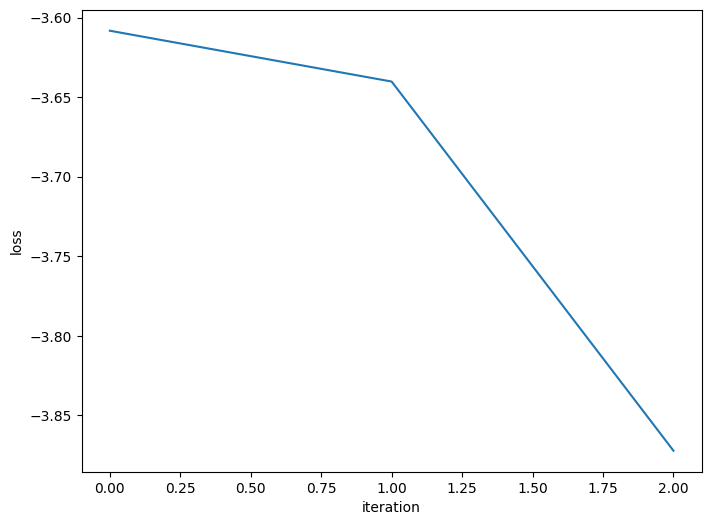

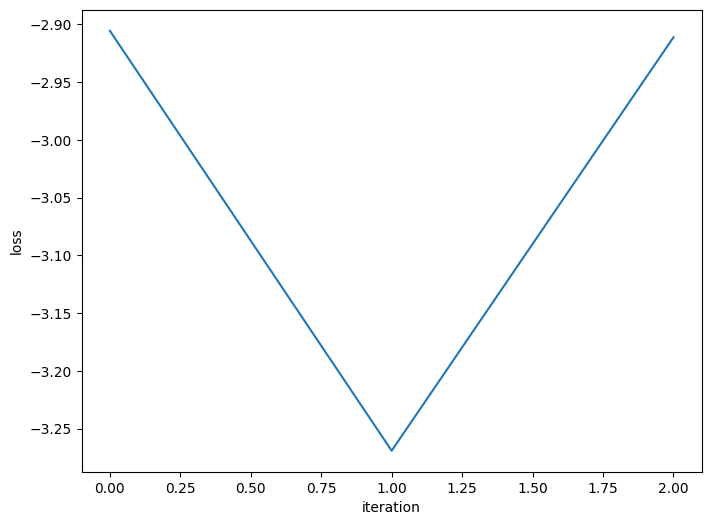

In [29]:
if policy_evaluation_iter<policy_evaluation_maxiter:
    loss_list.append(iwvi.eval_loss(weight_alpha=1.))
    normalized_loss_list.append(iwvi.eval_loss(weight_alpha=alpha))
if policy_evaluation_iter<policy_evaluation_maxiter:
    loss_array = np.array(loss_list)
    plt.figure(figsize=(8,6))
    plt.plot(loss_array[:,0])
    plt.xlabel("iteration")
    plt.ylabel("loss")
    plt.show()
    
    normalized_loss_array = np.array(normalized_loss_list)
    plt.figure(figsize=(8,6))
    plt.plot(normalized_loss_array[:,0])
    plt.xlabel("iteration")
    plt.ylabel("loss")


In [30]:
if policy_evaluation_iter<policy_evaluation_maxiter:
    train_curve1, valid_curve1 = iwvi.train_weighted_vae(num_iter=num_iter_max, lr=default_lr, early_stop_step=default_early, weight_alpha=alpha, flag=1)
    iwvi.update_mulogvar_offlinedata()


weight_alpha 0.1
train_weighted_vae: enc_dec
train: iter 0  trainloss -570.91481  validloss -511.51306±0.00000  bestvalidloss -511.51306  last_update 0
train: iter 1  trainloss -584.98391  validloss -509.71439±0.00000  bestvalidloss -511.51306  last_update 1
train: iter 2  trainloss -536.10234  validloss -515.58329±0.00000  bestvalidloss -515.58329  last_update 0
train: iter 3  trainloss -570.96731  validloss -477.50552±0.00000  bestvalidloss -515.58329  last_update 1
train: iter 4  trainloss -564.09674  validloss -498.73601±0.00000  bestvalidloss -515.58329  last_update 2
train: iter 5  trainloss -575.04228  validloss -499.62541±0.00000  bestvalidloss -515.58329  last_update 3
train: iter 6  trainloss -566.77337  validloss -507.25467±0.00000  bestvalidloss -515.58329  last_update 4
train: iter 7  trainloss -548.57718  validloss -421.98638±0.00000  bestvalidloss -515.58329  last_update 5
train: iter 8  trainloss -584.34543  validloss -510.39648±0.00000  bestvalidloss -515.58329  last_u

train: iter 76  trainloss -559.22947  validloss -478.92657±0.00000  bestvalidloss -522.46207  last_update 56
train: iter 77  trainloss -569.01543  validloss -486.97304±0.00000  bestvalidloss -522.46207  last_update 57
train: iter 78  trainloss -567.74079  validloss -487.85104±0.00000  bestvalidloss -522.46207  last_update 58
train: iter 79  trainloss -571.85470  validloss -496.79696±0.00000  bestvalidloss -522.46207  last_update 59
train: iter 80  trainloss -557.92641  validloss -488.93928±0.00000  bestvalidloss -522.46207  last_update 60
train: iter 81  trainloss -557.59584  validloss -449.37167±0.00000  bestvalidloss -522.46207  last_update 61
train: iter 82  trainloss -571.32949  validloss -495.08107±0.00000  bestvalidloss -522.46207  last_update 62
train: iter 83  trainloss -570.50256  validloss -507.80638±0.00000  bestvalidloss -522.46207  last_update 63
train: iter 84  trainloss -575.74604  validloss -479.27882±0.00000  bestvalidloss -522.46207  last_update 64
train: iter 85  tra

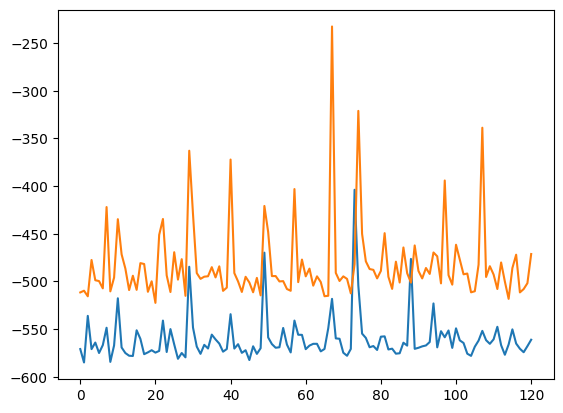

alpha 0.1 default_lr 0.0005


In [31]:
if policy_evaluation_iter<policy_evaluation_maxiter:
    plt.plot(train_curve1)
    plt.plot(valid_curve1)
    plt.show()

print("alpha",alpha, "default_lr", default_lr)

In [32]:
# iwvi.get_sim_rollout_bamdppolicy_data_fixlen()
# simdata0a = copy.deepcopy(iwvi.simenv_rolloutdata)
# iwvi.get_sim_rollout_bamdppolicy_data_fixlen()
# simdata0b = copy.deepcopy(iwvi.simenv_rolloutdata)
# # iwvi.get_sim_rollout_bamdppolicy_data_fixlen()
# # simdata0c = copy.deepcopy(iwvi.simenv_rolloutdata)



In [33]:
print(datetime.datetime.now())

2023-07-30 17:45:52.370629


# Iter 4

In [34]:
policy_evaluation_iter=3

In [35]:
if policy_evaluation_iter<policy_evaluation_maxiter:
    iwvi.get_sim_rollout_bamdppolicy_data_randomstop()


 0

 1

 2

 3

 4

 5

 6

 7

 8

 9

 10

 11

 12

 13

 14

 15

 16

 17

 18

 19

 20

 21

 22

 23

 24

 25

 26

 27

 28

 29

 30

 31

 32

 33

 34

 35

 36

 37

 38

 39

 40

 41

 42

 43

 44

 45

 46

 47

 48

 49

 50

 51

 52

 53

 54

 55

 56

 57

 58

 59
predict diverge [  2.55982724  14.10257431 -17.12887262 -31.69697198] [ 0.77998904 -1.53231554 -1.09003129 -8.32042829] [139.468     23.342175 153.2716    28.861576] [69.734    11.671087 76.6358   14.430788] sim_timestep 76

 60

 61

 62

 63

 64

 65

 66

 67

 68
predict diverge [ -0.99543743  19.87264333 -23.3350233  -40.79955242] [  0.74410431   3.79603064  -1.13833422 -14.59286029] [139.468     23.342175 153.2716    28.861576] [69.734    11.671087 76.6358   14.430788] sim_timestep 157

 69

 70

 71

 72

 73

 74

 75

 76

 77

 78

 79

 80

 81

 82

 83

 84

 85

 86

 87
predict diverge [  0.28518231  -3.14073099 -16.96690885 -33.24981565] [ 0.1802701  -7.08049404 -1.23446997 -6.5408427

In [36]:
if policy_evaluation_iter<policy_evaluation_maxiter:
    iwvi.train_ratio(num_iter=num_iter_max, lr=default_lr, early_stop_step=default_early, policy=agent.select_action)


train: iter 0  trainloss 0.28190  validloss 0.32999±0.00000  bestvalidloss 0.32999  last_update 0
train: iter 1  trainloss 0.26462  validloss 0.22981±0.00000  bestvalidloss 0.22981  last_update 0
train: iter 2  trainloss 0.25266  validloss 0.23723±0.00000  bestvalidloss 0.22981  last_update 1
train: iter 3  trainloss 0.24900  validloss 0.22771±0.00000  bestvalidloss 0.22771  last_update 0
train: iter 4  trainloss 0.24758  validloss 0.21987±0.00000  bestvalidloss 0.21987  last_update 0
train: iter 5  trainloss 0.24414  validloss 0.22296±0.00000  bestvalidloss 0.21987  last_update 1
train: iter 6  trainloss 0.24633  validloss 0.21634±0.00000  bestvalidloss 0.21634  last_update 0
train: iter 7  trainloss 0.24212  validloss 0.24473±0.00000  bestvalidloss 0.21634  last_update 1
train: iter 8  trainloss 0.23900  validloss 0.22016±0.00000  bestvalidloss 0.21634  last_update 2
train: iter 9  trainloss 0.23840  validloss 0.22554±0.00000  bestvalidloss 0.21634  last_update 3
train: iter 10  trai

train: iter 84  trainloss 0.20617  validloss 0.24064±0.00000  bestvalidloss 0.21634  last_update 78
train: iter 85  trainloss 0.20786  validloss 0.23254±0.00000  bestvalidloss 0.21634  last_update 79
train: iter 86  trainloss 0.20847  validloss 0.22475±0.00000  bestvalidloss 0.21634  last_update 80
train: iter 87  trainloss 0.20974  validloss 0.23990±0.00000  bestvalidloss 0.21634  last_update 81
train: iter 88  trainloss 0.20433  validloss 0.22640±0.00000  bestvalidloss 0.21634  last_update 82
train: iter 89  trainloss 0.20685  validloss 0.24648±0.00000  bestvalidloss 0.21634  last_update 83
train: iter 90  trainloss 0.20607  validloss 0.24620±0.00000  bestvalidloss 0.21634  last_update 84
train: iter 91  trainloss 0.20584  validloss 0.23239±0.00000  bestvalidloss 0.21634  last_update 85
train: iter 92  trainloss 0.20804  validloss 0.22483±0.00000  bestvalidloss 0.21634  last_update 86
train: iter 93  trainloss 0.20959  validloss 0.22072±0.00000  bestvalidloss 0.21634  last_update 87


train_loss:  -3.8080928018480535
valid_loss:  -5.054557459604739
weight_alpha 1.0 h_min_tilde -12.125036 ell_tilde -4.057385733399391 kappa_tilde 0.00035206792603175027
train_loss:  -3.0207102646827693
valid_loss:  -2.5490670398712156
weight_alpha 0.1 h_min_tilde -12.125036 ell_tilde -2.9263816197204586 kappa_tilde 0.0003297143457922894


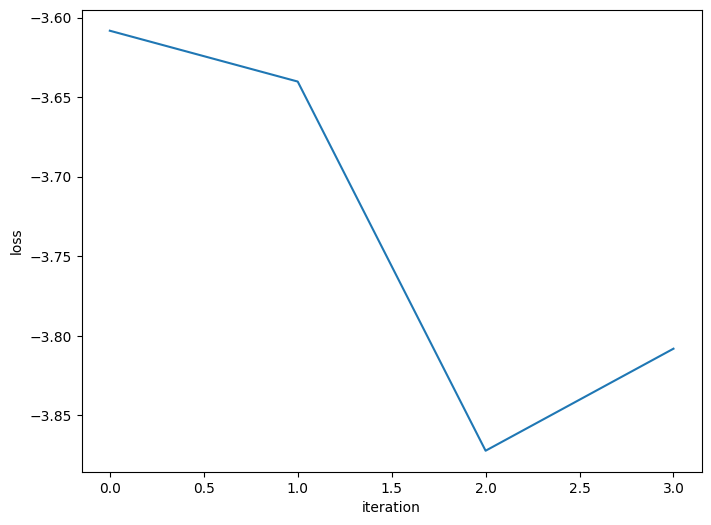

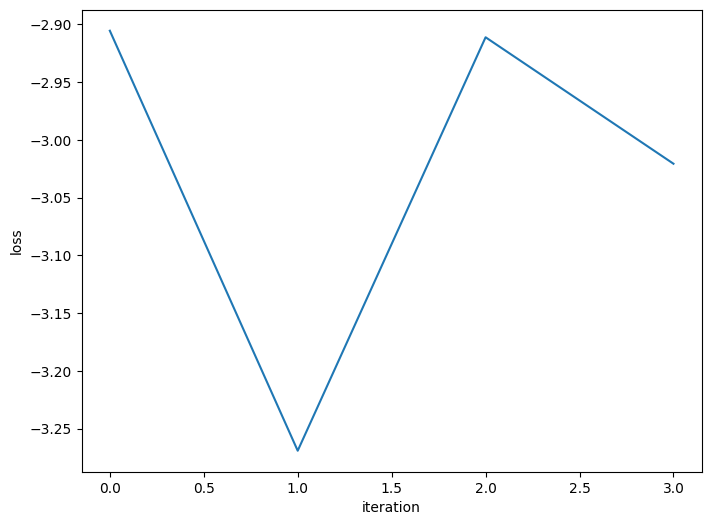

In [37]:
if policy_evaluation_iter<policy_evaluation_maxiter:
    loss_list.append(iwvi.eval_loss(weight_alpha=1.))
    normalized_loss_list.append(iwvi.eval_loss(weight_alpha=alpha))
if policy_evaluation_iter<policy_evaluation_maxiter:
    loss_array = np.array(loss_list)
    plt.figure(figsize=(8,6))
    plt.plot(loss_array[:,0])
    plt.xlabel("iteration")
    plt.ylabel("loss")
    plt.show()
    
    normalized_loss_array = np.array(normalized_loss_list)
    plt.figure(figsize=(8,6))
    plt.plot(normalized_loss_array[:,0])
    plt.xlabel("iteration")
    plt.ylabel("loss")

In [38]:
if policy_evaluation_iter<policy_evaluation_maxiter:
    train_curve1, valid_curve1 = iwvi.train_weighted_vae(num_iter=num_iter_max, lr=default_lr, early_stop_step=default_early, weight_alpha=alpha, flag=1)
    iwvi.update_mulogvar_offlinedata()


weight_alpha 0.1
train_weighted_vae: enc_dec
train: iter 0  trainloss -588.48586  validloss -512.51686±0.00000  bestvalidloss -512.51686  last_update 0
train: iter 1  trainloss -606.62058  validloss -524.60227±0.00000  bestvalidloss -524.60227  last_update 0
train: iter 2  trainloss -548.96384  validloss -494.60738±0.00000  bestvalidloss -524.60227  last_update 1
train: iter 3  trainloss -600.57231  validloss -512.48130±0.00000  bestvalidloss -524.60227  last_update 2
train: iter 4  trainloss -604.25154  validloss -525.00061±0.00000  bestvalidloss -525.00061  last_update 0
train: iter 5  trainloss -614.74150  validloss -530.00975±0.00000  bestvalidloss -530.00975  last_update 0
train: iter 6  trainloss -602.96213  validloss -510.39051±0.00000  bestvalidloss -530.00975  last_update 1
train: iter 7  trainloss -595.73795  validloss -520.86797±0.00000  bestvalidloss -530.00975  last_update 2
train: iter 8  trainloss -590.30056  validloss -454.07967±0.00000  bestvalidloss -530.00975  last_u

train: iter 76  trainloss -599.35177  validloss -490.30435±0.00000  bestvalidloss -539.17648  last_update 41
train: iter 77  trainloss -567.10360  validloss -517.88078±0.00000  bestvalidloss -539.17648  last_update 42
train: iter 78  trainloss -603.14285  validloss -466.94482±0.00000  bestvalidloss -539.17648  last_update 43
train: iter 79  trainloss -594.60726  validloss -519.10557±0.00000  bestvalidloss -539.17648  last_update 44
train: iter 80  trainloss -599.55258  validloss -495.53027±0.00000  bestvalidloss -539.17648  last_update 45
train: iter 81  trainloss -605.91408  validloss -514.21449±0.00000  bestvalidloss -539.17648  last_update 46
train: iter 82  trainloss -551.77762  validloss -524.68043±0.00000  bestvalidloss -539.17648  last_update 47
train: iter 83  trainloss -366.15873  validloss -210.31328±0.00000  bestvalidloss -539.17648  last_update 48
train: iter 84  trainloss -553.10949  validloss -411.05969±0.00000  bestvalidloss -539.17648  last_update 49
train: iter 85  tra

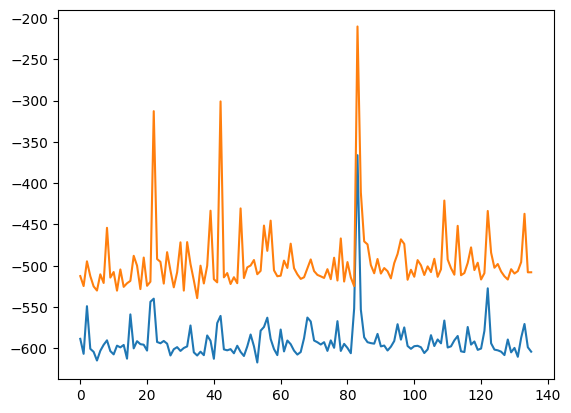

alpha 0.1 default_lr 0.0005


In [39]:
if policy_evaluation_iter<policy_evaluation_maxiter:
    plt.plot(train_curve1)
    plt.plot(valid_curve1)
    plt.show()

print("alpha",alpha, "default_lr", default_lr)

In [40]:
print(datetime.datetime.now())

2023-07-30 18:08:49.965718


# Iter 5

In [41]:
policy_evaluation_iter=4

In [42]:
if policy_evaluation_iter<policy_evaluation_maxiter:
    iwvi.get_sim_rollout_bamdppolicy_data_randomstop()


 0

 1

 2

 3

 4

 5

 6

 7

 8

 9

 10

 11

 12

 13

 14

 15

 16

 17

 18

 19

 20

 21

 22

 23

 24

 25

 26

 27

 28

 29

 30

 31

 32

 33

 34

 35

 36

 37

 38

 39

 40

 41

 42

 43

 44

 45

 46

 47

 48

 49

 50

 51

 52

 53

 54

 55

 56

 57

 58

 59

 60

 61

 62

 63

 64

 65

 66

 67

 68

 69

 70

 71

 72

 73

 74

 75

 76

 77

 78

 79

 80

 81

 82

 83

 84

 85

 86

 87

 88

 89

 90

 91

 92

 93

 94

 95

 96

 97

 98

 99
 


In [43]:
if policy_evaluation_iter<policy_evaluation_maxiter:
    iwvi.train_ratio(num_iter=num_iter_max, lr=default_lr, early_stop_step=default_early, policy=agent.select_action)


train: iter 0  trainloss 0.29684  validloss 0.26051±0.00000  bestvalidloss 0.26051  last_update 0
train: iter 1  trainloss 0.26396  validloss 0.21774±0.00000  bestvalidloss 0.21774  last_update 0
train: iter 2  trainloss 0.26261  validloss 0.21350±0.00000  bestvalidloss 0.21350  last_update 0
train: iter 3  trainloss 0.25512  validloss 0.21865±0.00000  bestvalidloss 0.21350  last_update 1
train: iter 4  trainloss 0.25468  validloss 0.23260±0.00000  bestvalidloss 0.21350  last_update 2
train: iter 5  trainloss 0.25266  validloss 0.21351±0.00000  bestvalidloss 0.21350  last_update 3
train: iter 6  trainloss 0.24897  validloss 0.22843±0.00000  bestvalidloss 0.21350  last_update 4
train: iter 7  trainloss 0.24981  validloss 0.24039±0.00000  bestvalidloss 0.21350  last_update 5
train: iter 8  trainloss 0.24854  validloss 0.22687±0.00000  bestvalidloss 0.21350  last_update 6
train: iter 9  trainloss 0.24877  validloss 0.23434±0.00000  bestvalidloss 0.21350  last_update 7
train: iter 10  trai

train: iter 83  trainloss 0.21563  validloss 0.22426±0.00000  bestvalidloss 0.21350  last_update 81
train: iter 84  trainloss 0.21347  validloss 0.22733±0.00000  bestvalidloss 0.21350  last_update 82
train: iter 85  trainloss 0.21814  validloss 0.23379±0.00000  bestvalidloss 0.21350  last_update 83
train: iter 86  trainloss 0.21383  validloss 0.23218±0.00000  bestvalidloss 0.21350  last_update 84
train: iter 87  trainloss 0.21393  validloss 0.23039±0.00000  bestvalidloss 0.21350  last_update 85
train: iter 88  trainloss 0.21457  validloss 0.22996±0.00000  bestvalidloss 0.21350  last_update 86
train: iter 89  trainloss 0.21316  validloss 0.24021±0.00000  bestvalidloss 0.21350  last_update 87
train: iter 90  trainloss 0.21356  validloss 0.23028±0.00000  bestvalidloss 0.21350  last_update 88
train: iter 91  trainloss 0.21576  validloss 0.22396±0.00000  bestvalidloss 0.21350  last_update 89
train: iter 92  trainloss 0.21173  validloss 0.22423±0.00000  bestvalidloss 0.21350  last_update 90


train_loss:  -3.040806831407547
valid_loss:  -3.6522442747712134
weight_alpha 1.0 h_min_tilde -11.98343 ell_tilde -3.16309432008028 kappa_tilde 0.00033671110921812804
train_loss:  -2.9795123967170714
valid_loss:  -2.590525899887085
weight_alpha 0.1 h_min_tilde -11.98343 ell_tilde -2.901715097351074 kappa_tilde 0.00033183032322519956


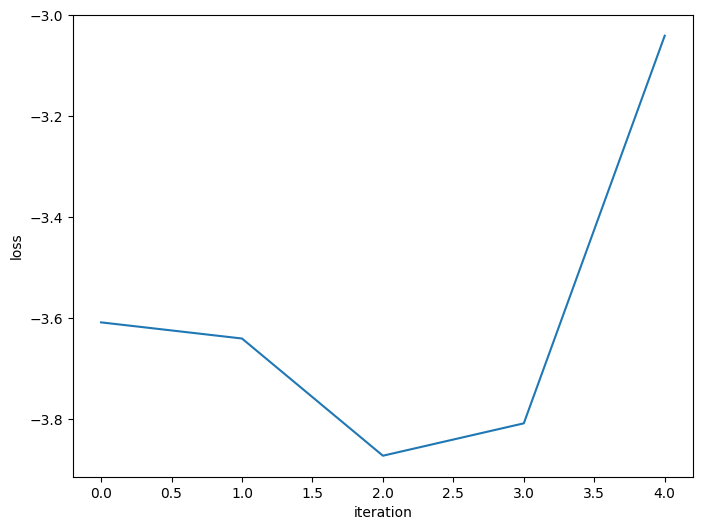

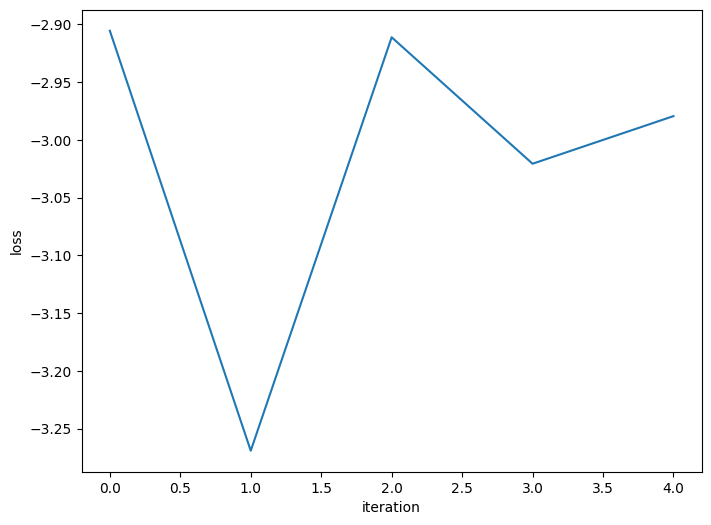

In [44]:
if policy_evaluation_iter<policy_evaluation_maxiter:
    loss_list.append(iwvi.eval_loss(weight_alpha=1.))
    normalized_loss_list.append(iwvi.eval_loss(weight_alpha=alpha))
if policy_evaluation_iter<policy_evaluation_maxiter:
    loss_array = np.array(loss_list)
    plt.figure(figsize=(8,6))
    plt.plot(loss_array[:,0])
    plt.xlabel("iteration")
    plt.ylabel("loss")
    plt.show()
    
    normalized_loss_array = np.array(normalized_loss_list)
    plt.figure(figsize=(8,6))
    plt.plot(normalized_loss_array[:,0])
    plt.xlabel("iteration")
    plt.ylabel("loss")

In [45]:
if policy_evaluation_iter<policy_evaluation_maxiter:
    train_curve1, valid_curve1 = iwvi.train_weighted_vae(num_iter=num_iter_max, lr=default_lr, early_stop_step=default_early, weight_alpha=alpha, flag=1)
    iwvi.update_mulogvar_offlinedata()


weight_alpha 0.1
train_weighted_vae: enc_dec
train: iter 0  trainloss -587.87387  validloss -514.95221±0.00000  bestvalidloss -514.95221  last_update 0
train: iter 1  trainloss -595.28456  validloss -527.70950±0.00000  bestvalidloss -527.70950  last_update 0
train: iter 2  trainloss -577.24968  validloss -499.26892±0.00000  bestvalidloss -527.70950  last_update 1
train: iter 3  trainloss -587.62676  validloss -515.38094±0.00000  bestvalidloss -527.70950  last_update 2
train: iter 4  trainloss -555.71343  validloss -451.41675±0.00000  bestvalidloss -527.70950  last_update 3
train: iter 5  trainloss -588.40902  validloss -467.84787±0.00000  bestvalidloss -527.70950  last_update 4
train: iter 6  trainloss -606.81173  validloss -513.67822±0.00000  bestvalidloss -527.70950  last_update 5
train: iter 7  trainloss -606.67811  validloss -513.51854±0.00000  bestvalidloss -527.70950  last_update 6
train: iter 8  trainloss -592.86164  validloss -530.21018±0.00000  bestvalidloss -530.21018  last_u

train: iter 76  trainloss -600.30215  validloss -510.02209±0.00000  bestvalidloss -530.85052  last_update 61
train: iter 77  trainloss -599.21442  validloss -523.77380±0.00000  bestvalidloss -530.85052  last_update 62
train: iter 78  trainloss -580.09893  validloss -504.77034±0.00000  bestvalidloss -530.85052  last_update 63
train: iter 79  trainloss -552.84429  validloss -503.31228±0.00000  bestvalidloss -530.85052  last_update 64
train: iter 80  trainloss -553.22868  validloss -498.30821±0.00000  bestvalidloss -530.85052  last_update 65
train: iter 81  trainloss -606.02765  validloss -487.04939±0.00000  bestvalidloss -530.85052  last_update 66
train: iter 82  trainloss -590.71039  validloss -492.88635±0.00000  bestvalidloss -530.85052  last_update 67
train: iter 83  trainloss -600.60206  validloss -503.89422±0.00000  bestvalidloss -530.85052  last_update 68
train: iter 84  trainloss -599.47554  validloss -485.70946±0.00000  bestvalidloss -530.85052  last_update 69
train: iter 85  tra

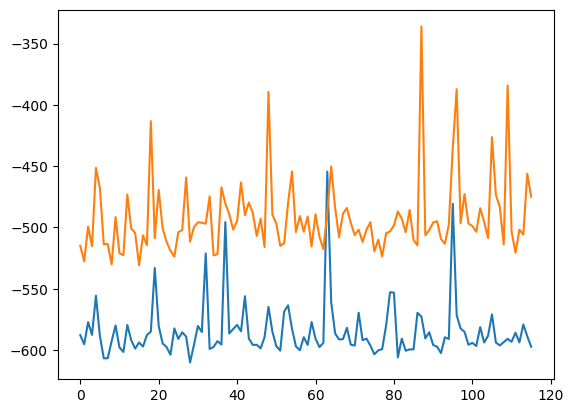

alpha 0.1 default_lr 0.0005


In [46]:
if policy_evaluation_iter<policy_evaluation_maxiter:
    plt.plot(train_curve1)
    plt.plot(valid_curve1)
    plt.show()

print("alpha",alpha, "default_lr", default_lr)

In [47]:
print(datetime.datetime.now())

2023-07-30 18:32:15.299743


# 評価関数計算

In [48]:
iwvi.get_sim_rollout_bamdppolicy_data_randomstop()


 0

 1

 2

 3

 4

 5

 6

 7

 8

 9

 10

 11

 12

 13

 14

 15

 16

 17

 18

 19

 20

 21

 22

 23

 24

 25

 26

 27

 28

 29

 30

 31

 32

 33

 34

 35

 36

 37

 38

 39

 40

 41

 42

 43

 44

 45

 46

 47

 48

 49

 50

 51

 52

 53

 54

 55

 56

 57

 58

 59

 60

 61

 62

 63

 64

 65

 66

 67

 68

 69

 70

 71

 72

 73

 74

 75

 76
predict diverge [14.5258495   1.55118043 65.98483313 33.82162179] [ 0.28829946 -2.99559623  1.67881582  6.54883576] [139.468     23.342175 153.2716    28.861576] [69.734    11.671087 76.6358   14.430788] sim_timestep 121

 77

 78

 79

 80

 81

 82

 83

 84

 85

 86

 87

 88

 89

 90

 91

 92

 93

 94

 95

 96

 97

 98

 99
 


In [49]:
iwvi.train_ratio(num_iter=num_iter_max, lr=default_lr, early_stop_step=default_early, policy=agent.select_action)


train: iter 0  trainloss 0.29262  validloss 0.36310±0.00000  bestvalidloss 0.36310  last_update 0
train: iter 1  trainloss 0.27499  validloss 0.29150±0.00000  bestvalidloss 0.29150  last_update 0
train: iter 2  trainloss 0.27133  validloss 0.28834±0.00000  bestvalidloss 0.28834  last_update 0
train: iter 3  trainloss 0.26531  validloss 0.28874±0.00000  bestvalidloss 0.28834  last_update 1
train: iter 4  trainloss 0.26371  validloss 0.27949±0.00000  bestvalidloss 0.27949  last_update 0
train: iter 5  trainloss 0.26440  validloss 0.27981±0.00000  bestvalidloss 0.27949  last_update 1
train: iter 6  trainloss 0.26118  validloss 0.28055±0.00000  bestvalidloss 0.27949  last_update 2
train: iter 7  trainloss 0.25473  validloss 0.27773±0.00000  bestvalidloss 0.27773  last_update 0
train: iter 8  trainloss 0.25661  validloss 0.27676±0.00000  bestvalidloss 0.27676  last_update 0
train: iter 9  trainloss 0.25318  validloss 0.28395±0.00000  bestvalidloss 0.27676  last_update 1
train: iter 10  trai

train: iter 83  trainloss 0.22706  validloss 0.27050±0.00000  bestvalidloss 0.26549  last_update 16
train: iter 84  trainloss 0.22866  validloss 0.27847±0.00000  bestvalidloss 0.26549  last_update 17
train: iter 85  trainloss 0.22680  validloss 0.26959±0.00000  bestvalidloss 0.26549  last_update 18
train: iter 86  trainloss 0.22791  validloss 0.27088±0.00000  bestvalidloss 0.26549  last_update 19
train: iter 87  trainloss 0.22854  validloss 0.28008±0.00000  bestvalidloss 0.26549  last_update 20
train: iter 88  trainloss 0.22441  validloss 0.27982±0.00000  bestvalidloss 0.26549  last_update 21
train: iter 89  trainloss 0.22716  validloss 0.27475±0.00000  bestvalidloss 0.26549  last_update 22
train: iter 90  trainloss 0.22768  validloss 0.28855±0.00000  bestvalidloss 0.26549  last_update 23
train: iter 91  trainloss 0.22642  validloss 0.27696±0.00000  bestvalidloss 0.26549  last_update 24
train: iter 92  trainloss 0.22846  validloss 0.29604±0.00000  bestvalidloss 0.26549  last_update 25


train: iter 165  trainloss 0.21235  validloss 0.27602±0.00000  bestvalidloss 0.26248  last_update 4
train: iter 166  trainloss 0.21682  validloss 0.29590±0.00000  bestvalidloss 0.26248  last_update 5
train: iter 167  trainloss 0.21601  validloss 0.28347±0.00000  bestvalidloss 0.26248  last_update 6
train: iter 168  trainloss 0.21433  validloss 0.27526±0.00000  bestvalidloss 0.26248  last_update 7
train: iter 169  trainloss 0.21414  validloss 0.28291±0.00000  bestvalidloss 0.26248  last_update 8
train: iter 170  trainloss 0.21564  validloss 0.27472±0.00000  bestvalidloss 0.26248  last_update 9
train: iter 171  trainloss 0.21399  validloss 0.28930±0.00000  bestvalidloss 0.26248  last_update 10
train: iter 172  trainloss 0.21314  validloss 0.28648±0.00000  bestvalidloss 0.26248  last_update 11
train: iter 173  trainloss 0.21340  validloss 0.27788±0.00000  bestvalidloss 0.26248  last_update 12
train: iter 174  trainloss 0.21281  validloss 0.29663±0.00000  bestvalidloss 0.26248  last_update

train: iter 247  trainloss 0.20592  validloss 0.28665±0.00000  bestvalidloss 0.26248  last_update 86
train: iter 248  trainloss 0.20145  validloss 0.27418±0.00000  bestvalidloss 0.26248  last_update 87
train: iter 249  trainloss 0.20413  validloss 0.27476±0.00000  bestvalidloss 0.26248  last_update 88
train: iter 250  trainloss 0.20500  validloss 0.28125±0.00000  bestvalidloss 0.26248  last_update 89
train: iter 251  trainloss 0.20534  validloss 0.29700±0.00000  bestvalidloss 0.26248  last_update 90
train: iter 252  trainloss 0.20194  validloss 0.28451±0.00000  bestvalidloss 0.26248  last_update 91
train: iter 253  trainloss 0.20360  validloss 0.29602±0.00000  bestvalidloss 0.26248  last_update 92
train: iter 254  trainloss 0.20341  validloss 0.27677±0.00000  bestvalidloss 0.26248  last_update 93
train: iter 255  trainloss 0.20565  validloss 0.27179±0.00000  bestvalidloss 0.26248  last_update 94
train: iter 256  trainloss 0.20502  validloss 0.28800±0.00000  bestvalidloss 0.26248  last_

([0.29261862551793455,
  0.27499322555959227,
  0.27132946816273035,
  0.265313976444304,
  0.2637122315354645,
  0.2644018494524062,
  0.26118237860500815,
  0.2547272313851863,
  0.2566068971529603,
  0.2531801958102733,
  0.2541789202950895,
  0.25316871162503957,
  0.2505504133179784,
  0.251078759226948,
  0.25071958573535086,
  0.2489131853915751,
  0.24878496024757624,
  0.2482994168996811,
  0.24990193089470267,
  0.24482695823535322,
  0.25022265771403907,
  0.24412178480997682,
  0.24777432521805168,
  0.24284079307690262,
  0.2448487696237862,
  0.24559340928681195,
  0.2424563725478947,
  0.24330730978399515,
  0.24185038153082133,
  0.24091210206970573,
  0.2382283302024007,
  0.23913137521594763,
  0.24290419854223727,
  0.23886853763833643,
  0.23993329294025897,
  0.24043048741295933,
  0.24261905001476408,
  0.23822367135435343,
  0.23819292457774283,
  0.23781159846112132,
  0.23961682403460144,
  0.23763012811541556,
  0.24089757464826106,
  0.23995720576494933,
  0.

In [50]:
loss_list.append(iwvi.eval_loss(weight_alpha=1.))
normalized_loss_list.append(iwvi.eval_loss(weight_alpha=alpha))


train_loss:  -4.000954414996505
valid_loss:  -4.712597806656361
weight_alpha 1.0 h_min_tilde -12.115204 ell_tilde -4.143283093328477 kappa_tilde 0.0003541754980426667
train_loss:  -3.0413815242767335
valid_loss:  -2.684374564361572
weight_alpha 0.1 h_min_tilde -12.115204 ell_tilde -2.9699801322937014 kappa_tilde 0.0003306761197326503


In [51]:
train_curve, valid_curve = iwvi.train_initial_belief(num_iter=100000, lr=1e-3, early_stop_step=default_early)


train: iter 0  trainloss 3.63908  validloss 3.65021±0.00000  bestvalidloss 3.65021  last_update 0
train: iter 1  trainloss 2.64492  validloss 2.49348±0.00000  bestvalidloss 2.49348  last_update 0
train: iter 2  trainloss 1.93830  validloss 1.80852±0.00000  bestvalidloss 1.80852  last_update 0
train: iter 3  trainloss 1.50229  validloss 1.24100±0.00000  bestvalidloss 1.24100  last_update 0
train: iter 4  trainloss 1.15927  validloss 0.94388±0.00000  bestvalidloss 0.94388  last_update 0
train: iter 5  trainloss 0.96035  validloss 0.71060±0.00000  bestvalidloss 0.71060  last_update 0
train: iter 6  trainloss 0.83099  validloss 0.51236±0.00000  bestvalidloss 0.51236  last_update 0
train: iter 7  trainloss 0.63581  validloss 0.36891±0.00000  bestvalidloss 0.36891  last_update 0
train: iter 8  trainloss 0.60093  validloss 0.41953±0.00000  bestvalidloss 0.36891  last_update 1
train: iter 9  trainloss 0.57364  validloss 0.39121±0.00000  bestvalidloss 0.36891  last_update 2
train: iter 10  trai

train: iter 97  trainloss 0.22089  validloss 0.11515±0.00000  bestvalidloss 0.04620  last_update 55
train: iter 98  trainloss 0.24610  validloss 0.11901±0.00000  bestvalidloss 0.04620  last_update 56
train: iter 99  trainloss 0.22557  validloss 0.15950±0.00000  bestvalidloss 0.04620  last_update 57
train: iter 100  trainloss 0.21139  validloss 0.09894±0.00000  bestvalidloss 0.04620  last_update 58
train: iter 101  trainloss 0.20823  validloss 0.14043±0.00000  bestvalidloss 0.04620  last_update 59
train: iter 102  trainloss 0.23461  validloss 0.04727±0.00000  bestvalidloss 0.04620  last_update 60
train: iter 103  trainloss 0.21210  validloss 0.09690±0.00000  bestvalidloss 0.04620  last_update 61
train: iter 104  trainloss 0.22217  validloss 0.13937±0.00000  bestvalidloss 0.04620  last_update 62
train: iter 105  trainloss 0.19136  validloss 0.12577±0.00000  bestvalidloss 0.04620  last_update 63
train: iter 106  trainloss 0.23300  validloss 0.04468±0.00000  bestvalidloss 0.04468  last_upd

train: iter 194  trainloss 0.22157  validloss 0.13734±0.00000  bestvalidloss 0.02308  last_update 12
train: iter 195  trainloss 0.22017  validloss 0.12797±0.00000  bestvalidloss 0.02308  last_update 13
train: iter 196  trainloss 0.21997  validloss 0.14832±0.00000  bestvalidloss 0.02308  last_update 14
train: iter 197  trainloss 0.22743  validloss 0.15964±0.00000  bestvalidloss 0.02308  last_update 15
train: iter 198  trainloss 0.21215  validloss 0.07835±0.00000  bestvalidloss 0.02308  last_update 16
train: iter 199  trainloss 0.22564  validloss 0.13220±0.00000  bestvalidloss 0.02308  last_update 17
train: iter 200  trainloss 0.24207  validloss 0.12439±0.00000  bestvalidloss 0.02308  last_update 18
train: iter 201  trainloss 0.19784  validloss 0.14010±0.00000  bestvalidloss 0.02308  last_update 19
train: iter 202  trainloss 0.21151  validloss 0.12565±0.00000  bestvalidloss 0.02308  last_update 20
train: iter 203  trainloss 0.23537  validloss 0.11862±0.00000  bestvalidloss 0.02308  last_

In [52]:
print(iwvi.initial_belief)


Parameter containing:
tensor([ 0.7199, -1.5847, -2.0595, -3.1545], requires_grad=True)


In [53]:
train_curve, valid_curve = iwvi.train_penalty(num_iter=num_iter_max, lr=default_lr, early_stop_step=default_early)

train: iter 0  trainloss 4.14389  validloss 5.49546±0.00000  bestvalidloss 5.49546  last_update 0
train: iter 1  trainloss 4.14779  validloss 6.55332±0.00000  bestvalidloss 5.49546  last_update 1
train: iter 2  trainloss 4.11050  validloss 6.08385±0.00000  bestvalidloss 5.49546  last_update 2
train: iter 3  trainloss 4.10282  validloss 6.61324±0.00000  bestvalidloss 5.49546  last_update 3
train: iter 4  trainloss 4.06578  validloss 6.14285±0.00000  bestvalidloss 5.49546  last_update 4
train: iter 5  trainloss 4.18759  validloss 6.26000±0.00000  bestvalidloss 5.49546  last_update 5
train: iter 6  trainloss 4.09748  validloss 5.92241±0.00000  bestvalidloss 5.49546  last_update 6
train: iter 7  trainloss 4.11263  validloss 5.95248±0.00000  bestvalidloss 5.49546  last_update 7
train: iter 8  trainloss 4.09912  validloss 6.74433±0.00000  bestvalidloss 5.49546  last_update 8
train: iter 9  trainloss 4.05376  validloss 6.33488±0.00000  bestvalidloss 5.49546  last_update 9
train: iter 10  trai

train: iter 84  trainloss 3.86241  validloss 7.03788±0.00000  bestvalidloss 5.49546  last_update 84
train: iter 85  trainloss 3.86127  validloss 6.66031±0.00000  bestvalidloss 5.49546  last_update 85
train: iter 86  trainloss 3.87141  validloss 6.40205±0.00000  bestvalidloss 5.49546  last_update 86
train: iter 87  trainloss 3.85407  validloss 6.65014±0.00000  bestvalidloss 5.49546  last_update 87
train: iter 88  trainloss 3.89249  validloss 7.10589±0.00000  bestvalidloss 5.49546  last_update 88
train: iter 89  trainloss 3.84503  validloss 6.51564±0.00000  bestvalidloss 5.49546  last_update 89
train: iter 90  trainloss 3.88757  validloss 6.30680±0.00000  bestvalidloss 5.49546  last_update 90
train: iter 91  trainloss 3.84109  validloss 6.45618±0.00000  bestvalidloss 5.49546  last_update 91
train: iter 92  trainloss 3.84533  validloss 6.79468±0.00000  bestvalidloss 5.49546  last_update 92
train: iter 93  trainloss 3.78609  validloss 6.50886±0.00000  bestvalidloss 5.49546  last_update 93


In [54]:
iwvi.save(ckpt_key="policy_optimization_iter1")

iwvi save ckpt1, ckpt2 ckpt_iwvi_basepartcartpole_policy_optimization_iter1 ckpt_iwvi_cartpole_policy_optimization_iter1
base save ckpt ckpt_basevi_cartpole_policy_optimization_iter1
base load self.initial_belief.data.sum() tensor(-6.0789)
base load dec.state_dict()['net_phat.0.weight'].sum() tensor(1.6307)


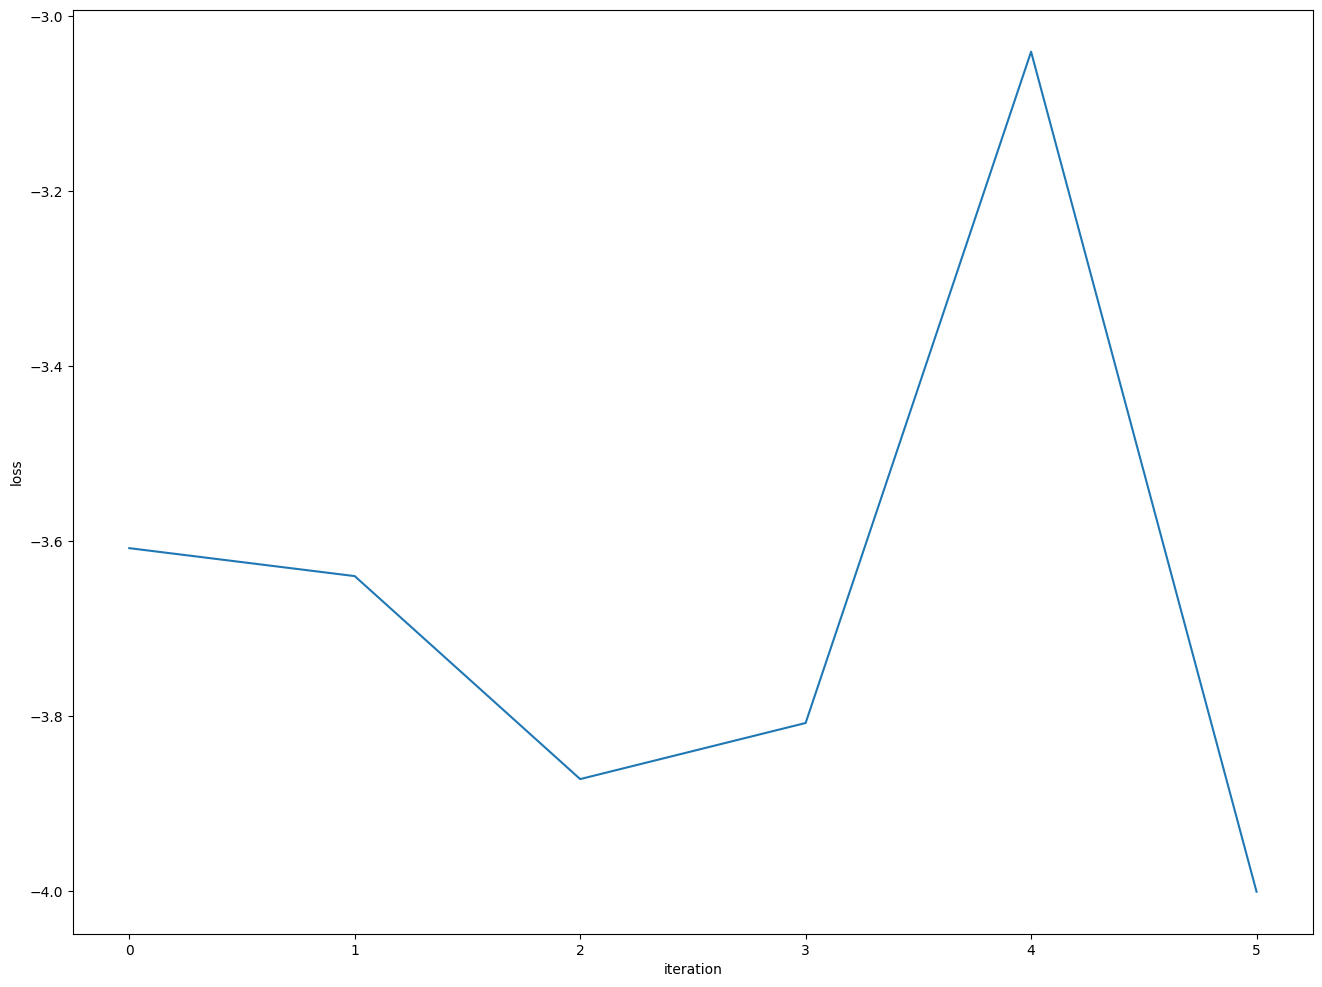

In [55]:
loss_array = np.array(loss_list)
plt.figure(figsize=(16,12))
plt.plot(loss_array[:,0])
plt.xlabel("iteration")
plt.ylabel("loss")
plt.savefig(figfilenamehead+"learning_curve.png")
plt.savefig(figfilenamehead+"learning_curve.eps")
# plt.savefig(figfilenamehead+"policy_evaluartion_learning_curve.pdf")

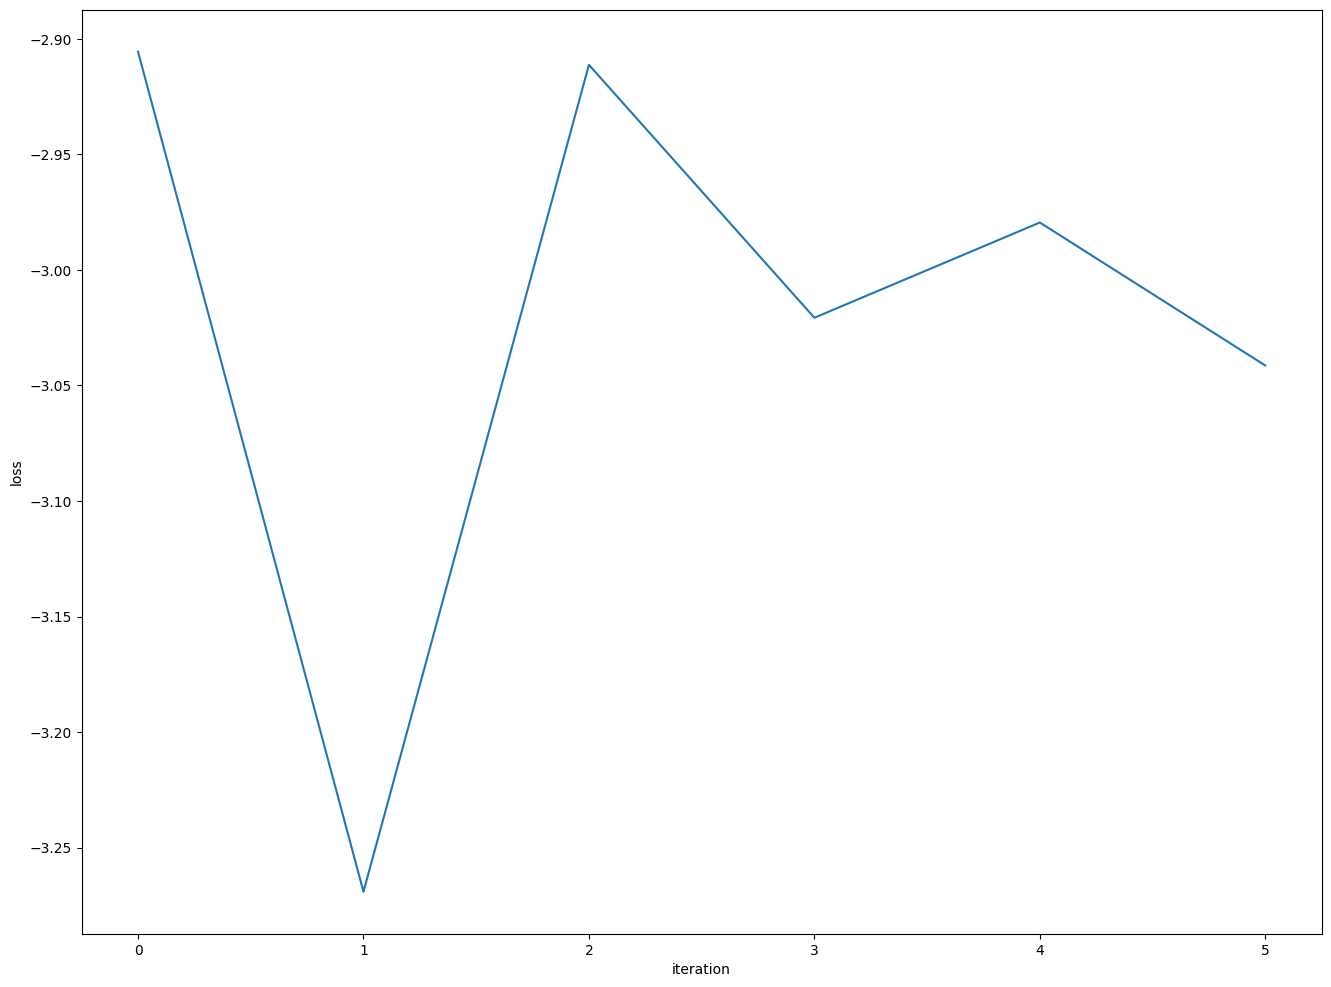

In [56]:
normalized_loss_array = np.array(normalized_loss_list)
plt.figure(figsize=(16,12))
plt.plot(normalized_loss_array[:,0])
plt.xlabel("iteration")
plt.ylabel("loss")
plt.savefig(figfilenamehead+"learning_curve_normalized_"+env_str+".png")
plt.savefig(figfilenamehead+"learning_curve_normalized_"+env_str+".eps")